# Group Project

## Loading the libraries

We first start by checking that all the necessary libraries are all downloaded, and we then load them

In [1]:
listofpackages <- c(
  "MASS",
  "WDI",
  "tidyr",
  "dplyr",
  "VIM",
  "httr",
  "jsonlite",
  "lmtest",
  "forecast",
  "nlme",
  "car",
  "ggplot2",
  "metafor",
  "maps",
  "tseries"
)
if (!require("democracyData")) {
  remotes::install_github("xmarquez/democracyData")
}
newpackages <- listofpackages[!(listofpackages %in% installed.packages()[,"Package"])]
if(length(newpackages)) install.packages(newpackages,
  dependencies = TRUE,
  repos = "http://cran.us.r-project.org"
)

Loading required package: democracyData



In [2]:
library(MASS)
library(WDI)
library(tidyr)
library(dplyr)
library(VIM)
library(httr)
library(jsonlite)
library(lmtest)
library(forecast)
library(nlme)
library(car)
library(ggplot2)
library(metafor)
library(democracyData)
library(maps)
library(tseries)

Warning message:
“package ‘MASS’ was built under R version 4.3.1”
Warning message:
“package ‘tidyr’ was built under R version 4.3.1”
Warning message:
“package ‘dplyr’ was built under R version 4.3.1”

Attaching package: ‘dplyr’


The following object is masked from ‘package:MASS’:

    select


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: colorspace

Loading required package: grid

VIM is ready to use.


Suggestions and bug-reports can be submitted at: https://github.com/statistikat/VIM/issues


Attaching package: ‘VIM’


The following object is masked from ‘package:datasets’:

    sleep


Warning message:
“package ‘jsonlite’ was built under R version 4.3.1”
Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Registered S3 method overwritten by 

## Data Retrieval

We retrieve data from 1995 to 2023 on the following indicators:
- GDP per capita (constant 2010 US$) - NY.GDP.PCAP.CD
- Gross national savings (% of GNI) - NY.GNS.ICTR.ZS
- Population growth (annual %) - SP.POP.GROW
- Fertility rate (total births per woman) - SP.DYN.TFRT.IN
- CO2 emissions (metric tons per capita) - EN.ATM.CO2E.PC
- Political Stability and Lack of Violence - PV.PER.RNK.LOWER, PV.PER.RNK.UPPER
- Research and development expenditure (% of GDP) - GB.XPD.RSDV.GD.ZS
- Freedom status estimation from the Freedom House
  
1995 was chosen as the starting point as this is after the fall of the Soviet Union and the end of the Yugoslav wars

In [3]:
start_date <- 1995
end_date <- 2023

gdp_per_capita <- WDI(country = "all",
  "NY.GDP.PCAP.CD",
  start = start_date,
  end = end_date
)

saving_rate <- WDI(country = "all",
  "NY.GNS.ICTR.ZS",
  start = start_date,
  end = end_date
)

population_growth <- WDI(country = "all",
  "SP.POP.GROW",
  start = start_date,
  end = end_date
)

fertility <- WDI(country = "all",
  "SP.DYN.TFRT.IN",
  start = start_date,
  end = end_date
)

co2_emission <- WDI(country = "all",
  "EN.ATM.CO2E.PC",
  start = start_date,
  end = end_date
)

pol_stability_lower <- WDI(country = "all",
  "PV.PER.RNK.LOWER",
  start = start_date,
  end = end_date
)

pol_stability_upper <- WDI(country = "all",
  "PV.PER.RNK.UPPER",
  start = start_date,
  end = end_date
)

research <- WDI(country = "all",
  "GB.XPD.RSDV.GD.ZS",
  start = start_date,
  end = end_date
)

dem_data  <- download_fh()

world_map <- map_data("world")

print("Downloaded the dataset")


Trying https://freedomhouse.org/sites/default/files/2023-02/Country_and_Territory_Ratings_and_Statuses_FIW_1973-2023%20.xlsx ...

The downloaded  dataset has 205 rows

Original dataset has 205 rows, but is not in country-year format

Processing the FH 2022 data - putting it in country-year format, adding state system info...

Warning message in download_fh():
“NAs introduced by coercion”
Warning message in download_fh():
“NAs introduced by coercion”
The following country names are different in the destination system:





|country                        |extended_country_name                   | GWn| cown| min_date| max_date|  n|
|:------------------------------|:---------------------------------------|---:|----:|--------:|--------:|--:|
|Antigua and Barbuda            |Antigua & Barbuda                       |  58|   58|     1982|     2022| 41|
|Belarus                        |Belarus (Byelorussia)                   | 370|  370|     1991|     2022| 32|
|Bosnia and Herzegovina         |Bosnia-Herzegovina                      | 346|  346|     1992|     2022| 31|
|Burkina Faso                   |Burkina Faso (Upper Volta)              | 439|  439|     1972|     2022| 50|
|Cabo Verde                     |Cape Verde                              | 402|  402|     1975|     2022| 47|
|Cambodia                       |Cambodia (Kampuchea)                    | 811|  811|     1972|     2022| 50|
|Congo (Brazzaville)            |Congo                                   | 484|  484|     1972|     2022| 50|
|Congo (

Resulting dataset after processing has 9045 rows.

Changing the name of the original country column from country to fh_country...

Ensuring year column is numeric...



[1] "Downloaded the dataset"


We create dummy variables for `Free` and `Partially Free` countries

In [4]:
dem_data <- dem_data %>% select(fh_country, year, status)
dem_data$dummy_PF <- ifelse(dem_data$status == "PF", 1, 0)
dem_data$dummy_F <- ifelse(dem_data$status == "F", 1, 0)
colnames(dem_data)[1] <- "country"
dem_data$status <- NULL

We create two dummy variables: one for countries whose distance from the equator is $\geq 60$ and one for countries whose distance from the equator is $\geq 30$ and $< 60$

In [5]:
country_centroids <- aggregate(
  cbind(long, lat) ~ region,
  data = world_map,
  FUN = function(x) median(range(x))
)
colnames(country_centroids) <- c("country", "longitude", "latitude")
country_centroids$longitude <- NULL
country_centroids$dummy_30_60 = ifelse(
  abs(country_centroids$latitude) >= 30 & abs(country_centroids$latitude) < 60,
  1,
  0
)
country_centroids$dummy_60_plus = ifelse(
  abs(country_centroids$latitude) >= 60,
  1,
  0
)
country_centroids$latitude <- NULL

We now merge and clean all the datasets

In [6]:
data_regression <- merge.data.frame(gdp_per_capita, saving_rate)
data_regression <- merge.data.frame(data_regression, population_growth)
data_regression <- merge.data.frame(data_regression, co2_emission)
data_regression <- merge.data.frame(data_regression, fertility)
data_regression <- merge.data.frame(data_regression, pol_stability_lower)
data_regression <- merge.data.frame(data_regression, research)
data_regression <- merge.data.frame(data_regression, pol_stability_upper)
data_regression <- merge.data.frame(data_regression, country_centroids)
last_year_observed <- max(data_regression$year)
dem_data <- dem_data %>% filter(year >= start_date & year <= last_year_observed)
data_regression <- merge.data.frame(data_regression, dem_data)
subsetted_data_regression = subset(data_regression, year == last_year_observed)
in_subset <- data_regression$country %in% subsetted_data_regression$country
data_regression <- data_regression[in_subset, ]
print("Merged the dataset")

[1] "Merged the dataset"


Sanity check to be sure that only countries are in the dataframe

In [7]:
print(paste("Number of unique countries:", length(unique(data_regression$country))))
print(unique(data_regression$country))

[1] "Number of unique countries: 163"
  [1] "Afghanistan"              "Albania"                 
  [3] "Algeria"                  "Andorra"                 
  [5] "Angola"                   "Argentina"               
  [7] "Armenia"                  "Australia"               
  [9] "Austria"                  "Azerbaijan"              
 [11] "Bahrain"                  "Bangladesh"              
 [13] "Barbados"                 "Belarus"                 
 [15] "Belgium"                  "Belize"                  
 [17] "Benin"                    "Bhutan"                  
 [19] "Bolivia"                  "Bosnia and Herzegovina"  
 [21] "Botswana"                 "Brazil"                  
 [23] "Bulgaria"                 "Burkina Faso"            
 [25] "Burundi"                  "Cambodia"                
 [27] "Cameroon"                 "Canada"                  
 [29] "Central African Republic" "Chad"                    
 [31] "Chile"                    "China"                   
 [

To remove any NaNs present in the data, we use k-Nearest Neighbours(kNN), a non-parametric model that imputes the value of a point based on the average values of the $k$ nearest points in the dataset. 

In [8]:
data_regression <- kNN(data_regression, k = 10)

To aggregate the upper and lower bound of corruption we use a weighted average, where the weights are calculated as followed 
- For the lower bound it is: $\frac{1}{2}+\frac{corruption_{*}}{200}$, which means that it starts at $\frac{1}{2}$ and linearly increases up to $1$, when $corruption_{*} = 100$ where $corruption_{*}$ is the lower bound of the corruption
- For the upper bound it is: $\frac{1}{2}+\frac{100-corruption^{*}}{200}$, which means that it starts at $1$ and linearly decreases up to $\frac{1}{2}$, when $corruption^{*} = 100$ where $corruption^{*}$ is the upper bound of the corruption

This is done to push away from the upper and lower bound the values, in order for it to be a meaningful predictor

In [9]:
weighted_average <- function(lower, upper) {
  weight_l <- 0.5 + (lower / 200)
  weight_u <- 0.5 + ((100 - upper) / 200)
  rtv <- (lower * weight_l + upper * weight_u) / (weight_l + weight_u)
  return(rtv)
}
data_regression$pol_stability <- mapply(
  weighted_average,
  data_regression$PV.PER.RNK.LOWER,
  data_regression$PV.PER.RNK.UPPER
)

We now ensure that all the necessary columns are in numerical form and remove any that are unnecessary for the assignment

In [10]:
data_regression$gdp <- as.numeric(data_regression$NY.GDP.PCAP.CD)
data_regression$saving <- as.numeric(data_regression$NY.GNS.ICTR.ZS)
data_regression$pop_growth <- as.numeric(data_regression$SP.POP.GROW)
data_regression$fertility <- as.numeric(data_regression$SP.DYN.TFRT.IN)
data_regression$co2_emission <- as.numeric(data_regression$EN.ATM.CO2E.PC)
data_regression$pol_stability <- as.numeric(data_regression$pol_stability)
data_regression$research <- as.numeric(data_regression$GB.XPD.RSDV.GD.ZS)

In [11]:
data_regression$iso2c <- NULL
data_regression$iso3c <- NULL
data_regression$NY.GDP.PCAP.CD <- NULL
data_regression$NY.GNS.ICTR.ZS <- NULL
data_regression$SP.POP.GROW <- NULL
data_regression$SP.DYN.TFRT.IN <- NULL
data_regression$EN.ATM.CO2E.PC <- NULL
data_regression$PV.PER.RNK.LOWER <- NULL
data_regression$PV.PER.RNK.UPPER <- NULL
data_regression$GB.XPD.RSDV.GD.ZS <- NULL
data_regression$country_imp <- NULL
data_regression$NY.GDP.PCAP.CD_imp <- NULL
data_regression$NY.GNS.ICTR.ZS_imp <- NULL
data_regression$SP.POP.GROW_imp <- NULL
data_regression$SP.DYN.TFRT.IN_imp <- NULL
data_regression$EN.ATM.CO2E.PC_imp <- NULL
data_regression$iso2c_imp <- NULL
data_regression$iso3c_imp <- NULL
data_regression$year_imp <- NULL
data_regression$PV.PER.RNK.LOWER_imp <- NULL
data_regression$PV.PER.RNK.UPPER_imp <- NULL
data_regression$GB.XPD.RSDV.GD.ZS_imp <- NULL
data_regression$dummy_F_imp <- NULL
data_regression$dummy_PF_imp <- NULL
data_regression$dummy_30_60_imp <- NULL
data_regression$dummy_60_plus_imp <- NULL

Taking the logarithms, removing any $\pm\infty$ generated by taking the logarithm and imputing the NaNs created

In [12]:
data_regression$gdp <- log(data_regression$gdp)
data_regression$saving <- log(data_regression$saving)
data_regression$pop_growth <- log(data_regression$pop_growth)
data_regression$co2_emission <- log(data_regression$co2_emission)
data_regression$fertility <- log(data_regression$fertility)
data_regression$research <- log(data_regression$research)

Warning message in log(data_regression$saving):
“NaNs produced”
Warning message in log(data_regression$pop_growth):
“NaNs produced”


In [13]:
data_regression$co2_emission  <- ifelse(
  is.infinite(
    data_regression$co2_emission
  ),
  NA,
  data_regression$co2_emission
)
data_regression$fertility  <- ifelse(
  is.infinite(
    data_regression$fertility
  ),
  NA,
  data_regression$fertility
)
data_regression$research  <- ifelse(
  is.infinite(
    data_regression$research
  ),
  NA,
  data_regression$research
)

In [14]:
data_regression <- kNN(data_regression, k = 10)
data_regression$country_imp <- NULL
data_regression$saving_imp <- NULL
data_regression$pop_growth_imp <- NULL
data_regression$gdp_imp <- NULL
data_regression$year_imp <- NULL
data_regression$co2_emission_imp <- NULL
data_regression$fertility_imp <- NULL
data_regression$pol_stability_imp <- NULL
data_regression$research_imp <- NULL
data_regression$dummy_PF_imp <- NULL
data_regression$dummy_F_imp <- NULL
data_regression$dummy_30_60_imp <- NULL
data_regression$dummy_60_plus_imp <- NULL

Sanity check to be sure that our dataset follows our expectations

In [15]:
print(colnames(data_regression))
print(summary(data_regression))

 [1] "country"       "year"          "dummy_30_60"   "dummy_60_plus"
 [5] "dummy_PF"      "dummy_F"       "pol_stability" "gdp"          
 [9] "saving"        "pop_growth"    "fertility"     "co2_emission" 
[13] "research"     
   country               year       dummy_30_60     dummy_60_plus    
 Length:4508        Min.   :1995   Min.   :0.0000   Min.   :0.00000  
 Class :character   1st Qu.:2002   1st Qu.:0.0000   1st Qu.:0.00000  
 Mode  :character   Median :2009   Median :0.0000   Median :0.00000  
                    Mean   :2009   Mean   :0.3647   Mean   :0.03106  
                    3rd Qu.:2016   3rd Qu.:1.0000   3rd Qu.:0.00000  
                    Max.   :2022   Max.   :1.0000   Max.   :1.00000  
    dummy_PF         dummy_F       pol_stability        gdp        
 Min.   :0.0000   Min.   :0.0000   Min.   : 0.00   Min.   : 4.676  
 1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:28.82   1st Qu.: 6.969  
 Median :0.0000   Median :0.0000   Median :47.78   Median : 8.268  
 Mean   :0

## Data Exploration

We will now explore the distributions of the various variables to better understand the problem at hand

### Scatter Plots

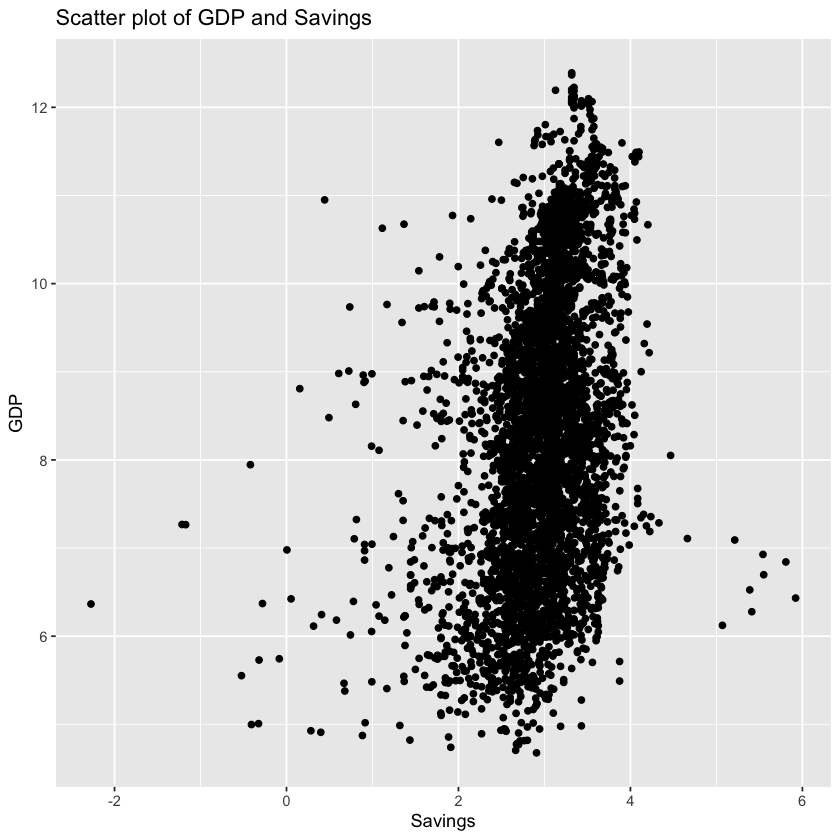

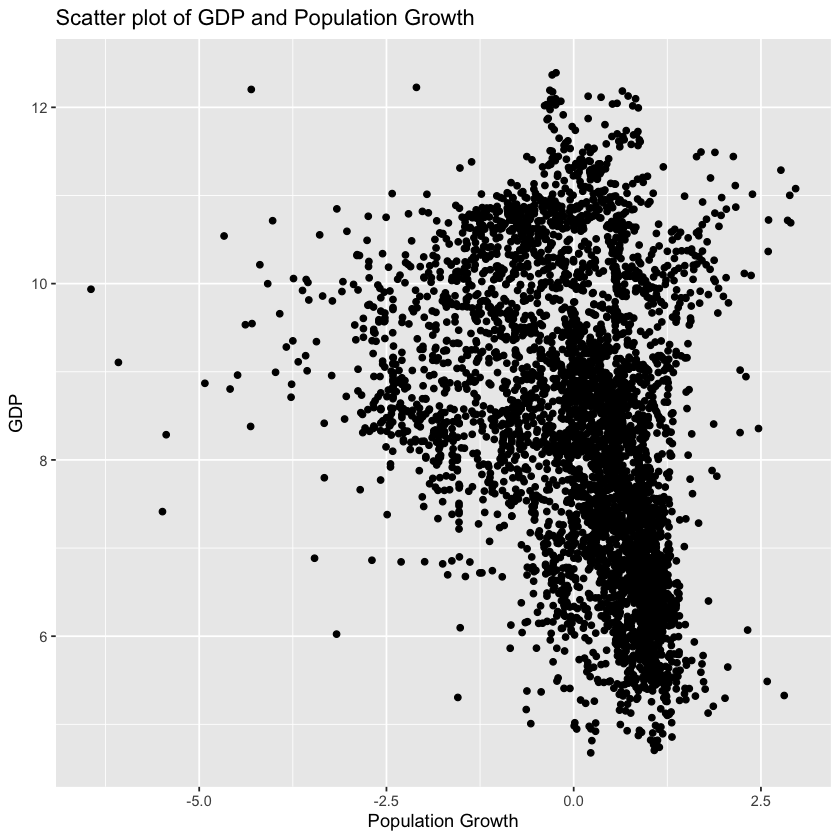

In [16]:
ggplot(data_regression, aes(x = saving, y = gdp)) +
  geom_point() +
  labs(title = "Scatter plot of GDP and Savings",
       x = "Savings",
       y = "GDP")
ggplot(data_regression, aes(x = pop_growth, y = gdp)) +
  geom_point() +
  labs(title = "Scatter plot of GDP and Population Growth",
       x = "Population Growth",
       y = "GDP")

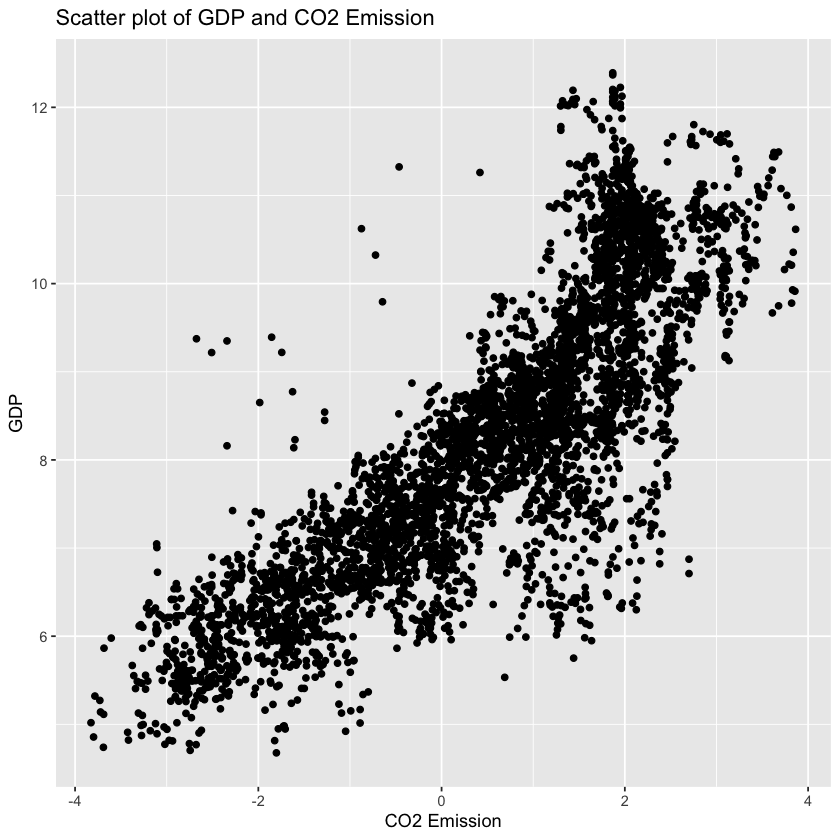

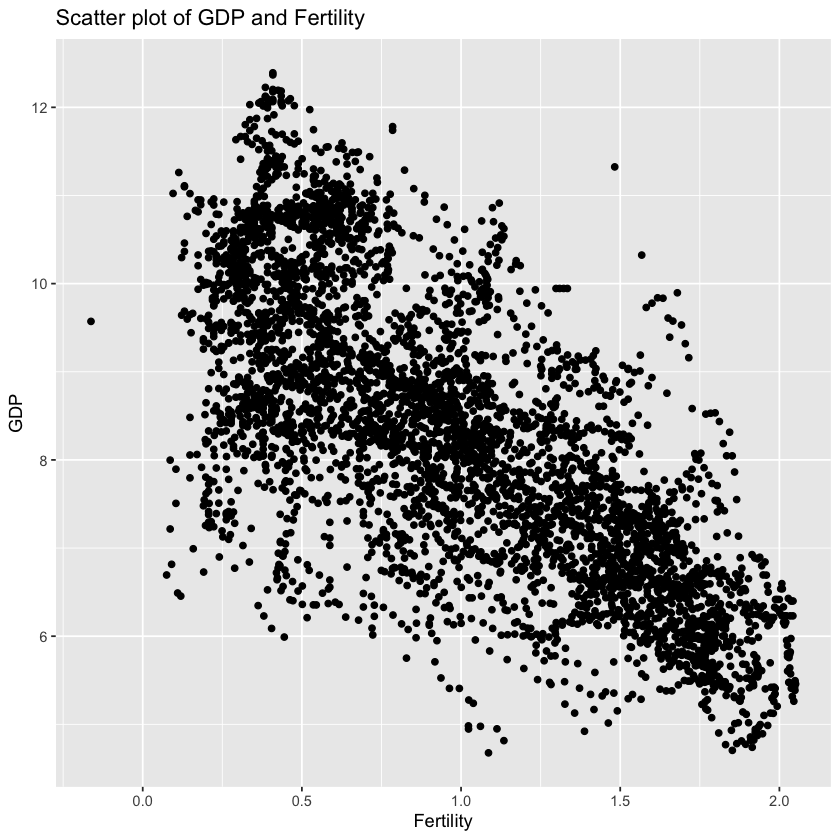

In [17]:
ggplot(data_regression, aes(x = co2_emission, y = gdp)) +
  geom_point() +
  labs(title = "Scatter plot of GDP and CO2 Emission",
       x = "CO2 Emission",
       y = "GDP")
ggplot(data_regression, aes(x = fertility, y = gdp)) +
  geom_point() +
  labs(title = "Scatter plot of GDP and Fertility",
       x = "Fertility",
       y = "GDP")

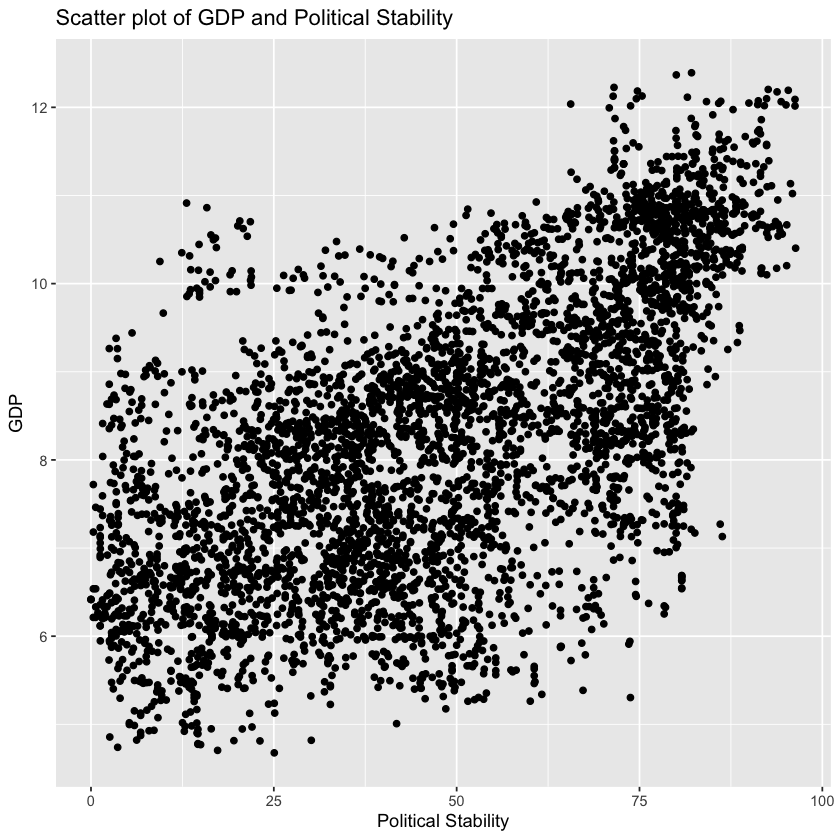

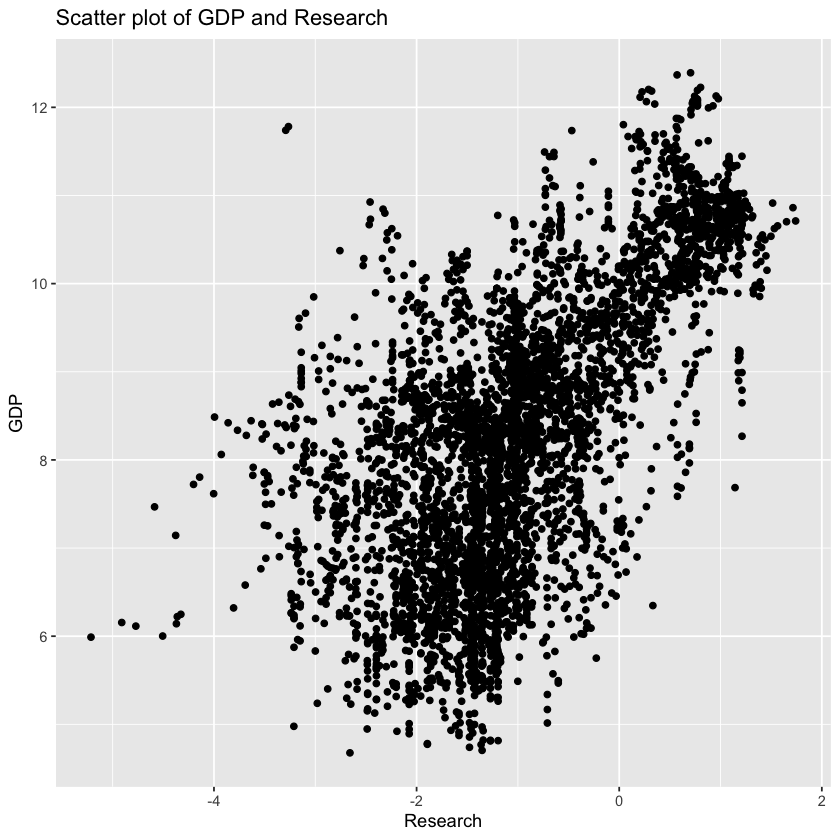

In [18]:
ggplot(data_regression, aes(x = pol_stability, y = gdp)) +
  geom_point() +
  labs(title = "Scatter plot of GDP and Political Stability",
       x = "Political Stability",
       y = "GDP")
ggplot(data_regression, aes(x = research, y = gdp)) +
  geom_point() +
  labs(title = "Scatter plot of GDP and Research",
       x = "Research",
       y = "GDP")

From the plots we can infer that:
- GDP and Savings are mostly uncorrelated, with most observations of Saving being around 3
- There seems to be a correlation between GDP and the other predictors, with varying degree of variance

### Histograms

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead.”


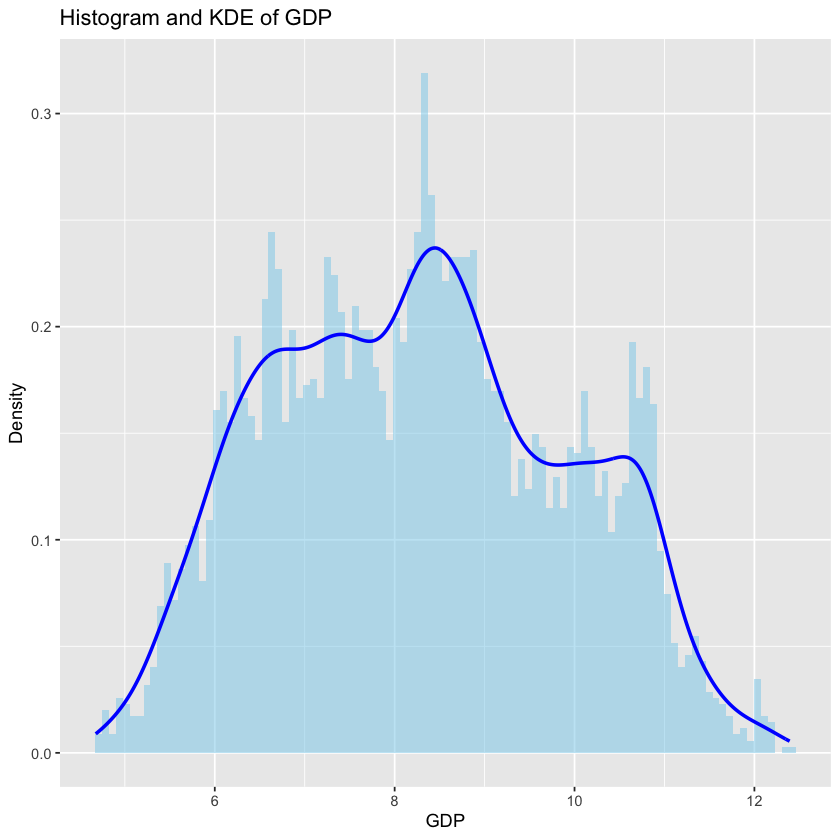

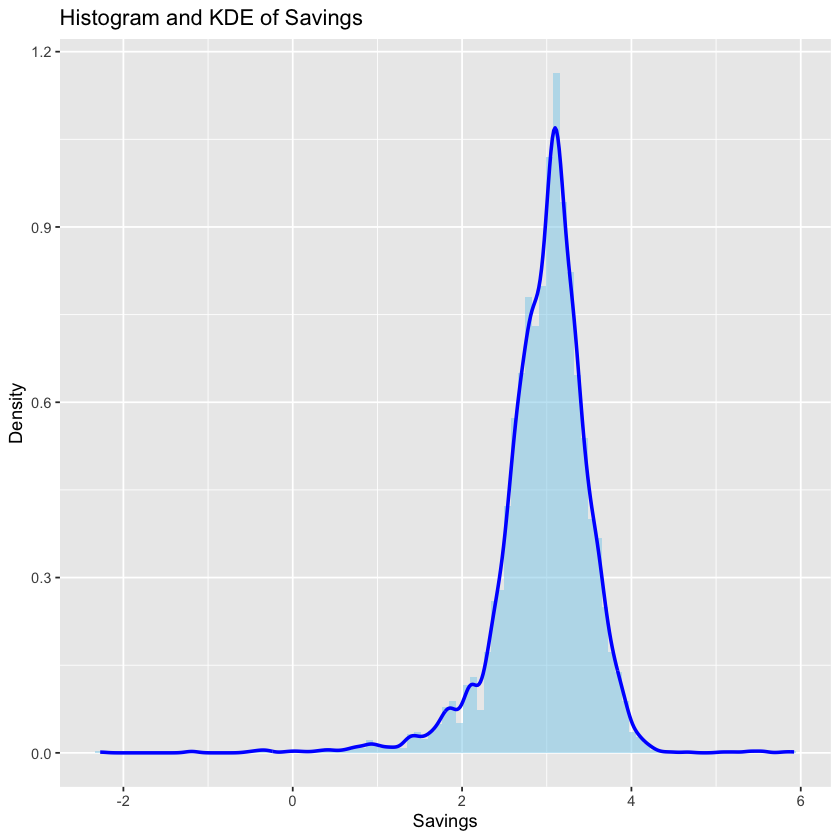

In [19]:
ggplot(data_regression, aes(x = gdp)) +
  geom_histogram(aes(y = ..density..),
    binwidth = diff(range(data_regression$gdp)) / 100,
    fill = "skyblue",
    alpha = 0.5
  ) +
  geom_density(aes(y = ..density..),
    color = "blue",
    size = 1
  ) +
  labs(title = "Histogram and KDE of GDP",
    x = "GDP",
    y = "Density"
  )
ggplot(data_regression, aes(x = saving)) +
  geom_histogram(aes(y = ..density..),
    binwidth = diff(range(data_regression$saving)) / 100,
    fill = "skyblue",
    alpha = 0.5
  ) +
  geom_density(aes(y = ..density..),
    color = "blue",
    size = 1
  ) +
  labs(title = "Histogram and KDE of Savings",
    x = "Savings",
    y = "Density"
  )

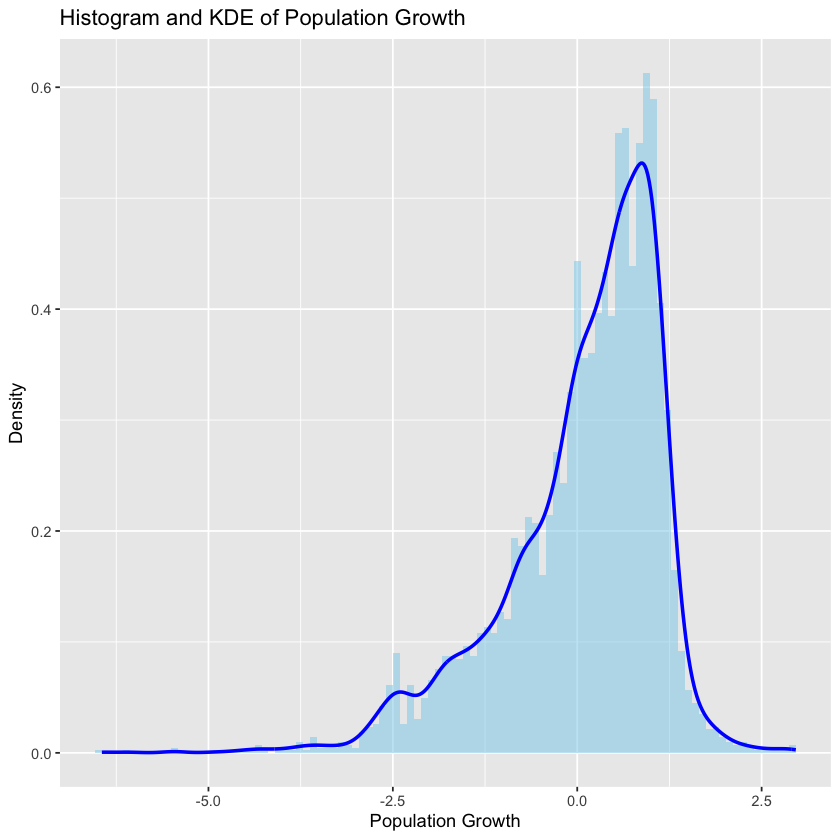

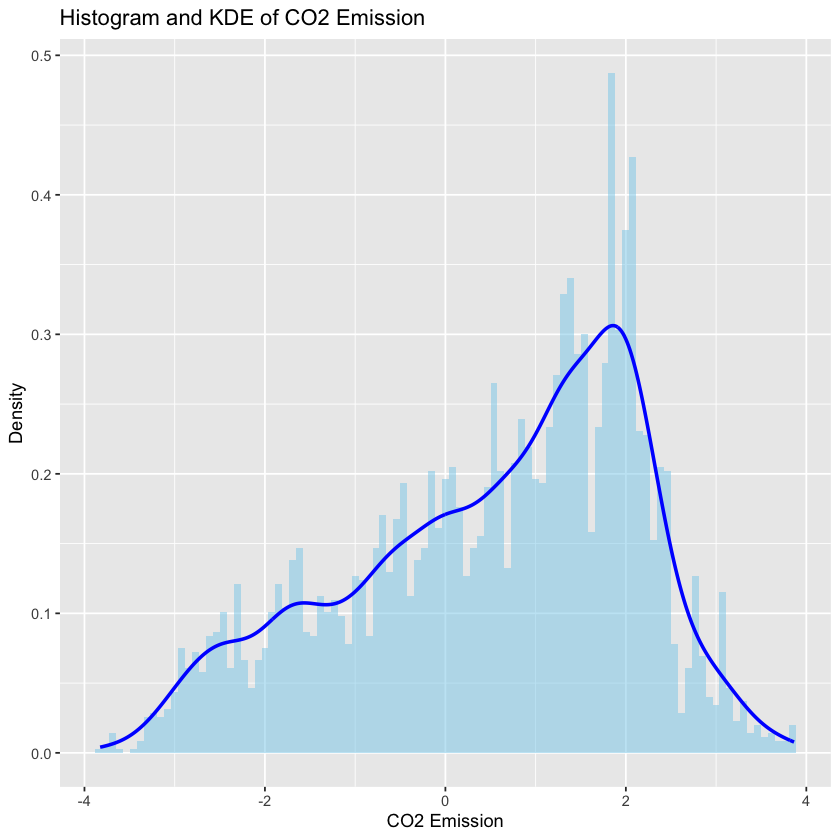

In [20]:
ggplot(data_regression, aes(x = pop_growth)) +
  geom_histogram(aes(y = ..density..),
    binwidth = diff(range(data_regression$pop_growth)) / 100,
    fill = "skyblue",
    alpha = 0.5
  ) +
  geom_density(aes(y = ..density..),
    color = "blue",
    size = 1
  ) +
  labs(title = "Histogram and KDE of Population Growth",
    x = "Population Growth",
    y = "Density"
  )
ggplot(data_regression, aes(x = co2_emission)) +
  geom_histogram(aes(y = ..density..),
    binwidth = diff(range(data_regression$co2_emission)) / 100,
    fill = "skyblue",
    alpha = 0.5
  ) +
  geom_density(aes(y = ..density..),
    color = "blue",
    size = 1
  ) +
  labs(title = "Histogram and KDE of CO2 Emission",
    x = "CO2 Emission",
    y = "Density"
  )

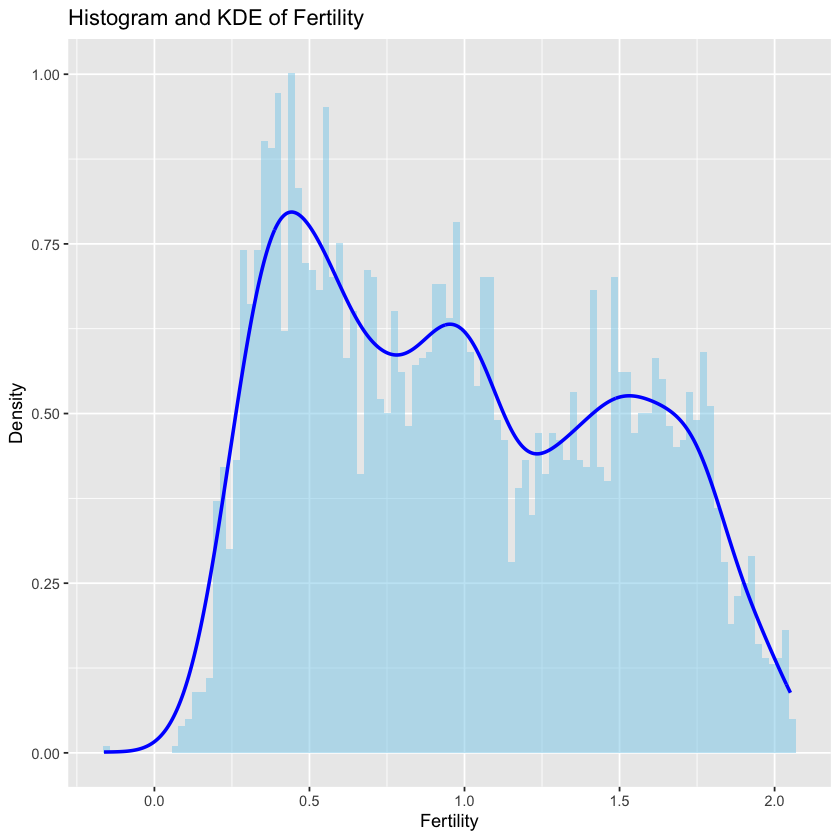

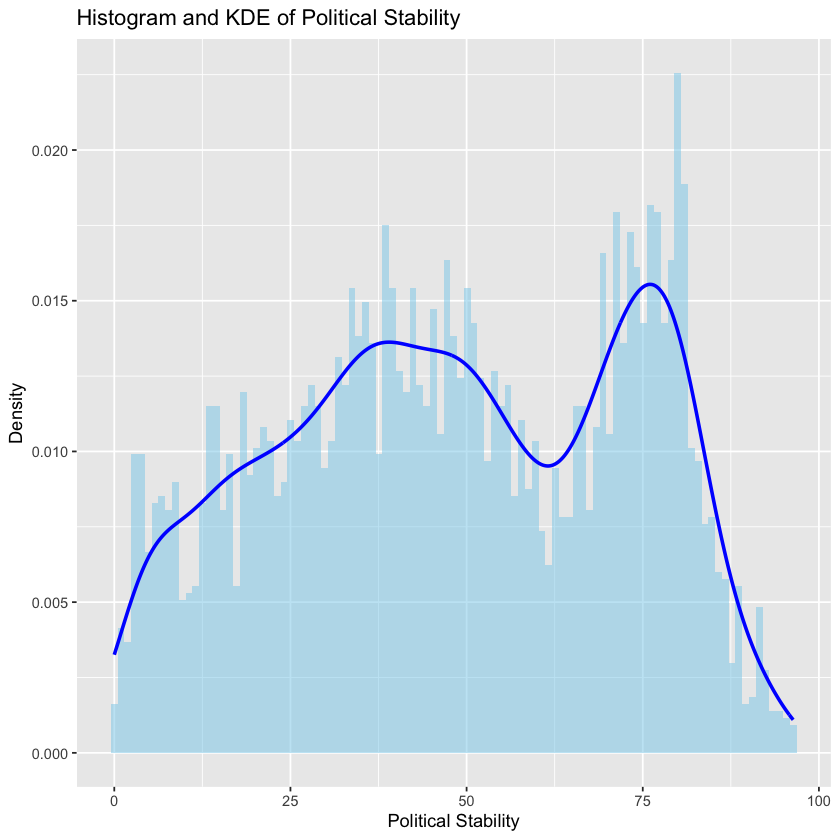

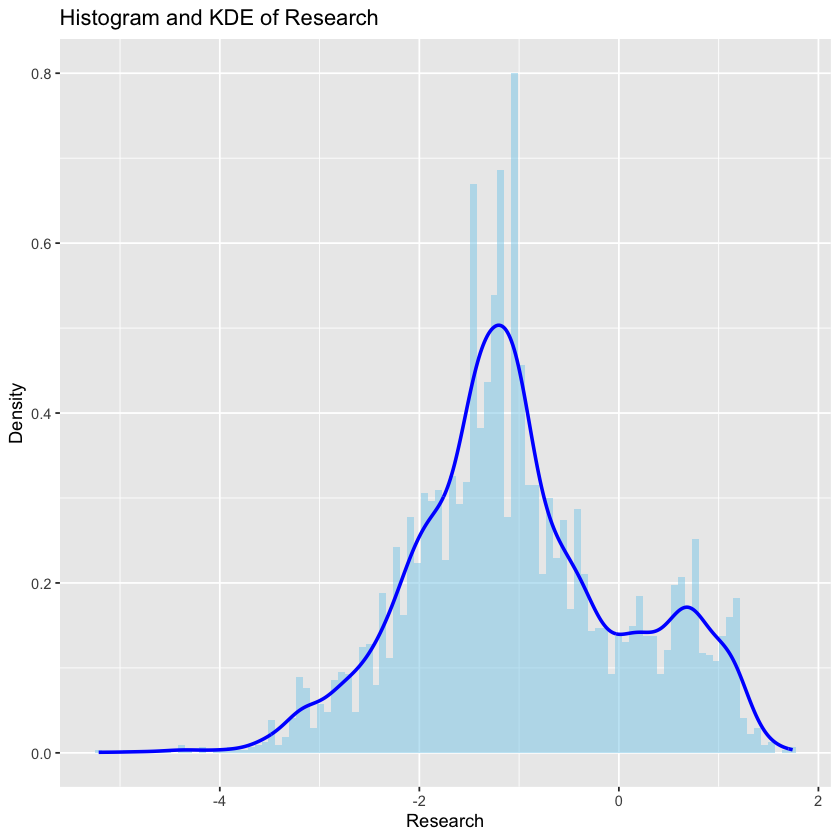

In [21]:
ggplot(data_regression, aes(x = fertility)) +
  geom_histogram(aes(y = ..density..),
    binwidth = diff(range(data_regression$fertility)) / 100,
    fill = "skyblue",
    alpha = 0.5
  ) +
  geom_density(aes(y = ..density..),
    color = "blue",
    size = 1
  ) +
  labs(title = "Histogram and KDE of Fertility",
    x = "Fertility",
    y = "Density"
  )
ggplot(data_regression, aes(x = pol_stability)) +
  geom_histogram(aes(y = ..density..),
    binwidth = diff(range(data_regression$pol_stability)) / 100,
    fill = "skyblue",
    alpha = 0.5
  ) +
  geom_density(aes(y = ..density..),
    color = "blue",
    size = 1
  ) +
  labs(title = "Histogram and KDE of Political Stability",
    x = "Political Stability",
    y = "Density"
  )
ggplot(data_regression, aes(x = research)) +
  geom_histogram(aes(y = ..density..),
    binwidth = diff(range(data_regression$research)) / 100,
    fill = "skyblue",
    alpha = 0.5
  ) +
  geom_density(aes(y = ..density..),
    color = "blue",
    size = 1
  ) +
  labs(title = "Histogram and KDE of Research",
    x = "Research",
    y = "Density"
  )

From here we can infer that:
- GDP observations roughly follow a normal distribution, albeit with a very high variance and mean around 9
- Savings observations roughly follow a normal distribution, with a very small variance and with mean around 3
- CO2 Emission observations and Fertility are left skewed
- Corruption looks evenly spread, with a dropoff after 80
- Research is somewhat left skewed

### Box and Violin Plots

We thought it was worthwhile also exploring the distribution with respect to our dummy variables.

In [22]:
data_regression <- data_regression %>%
  mutate(FreedomStatus = case_when(
    dummy_PF == 1 ~ "Partially Free",
    dummy_F == 1 ~ "Free",
    TRUE ~ "Not Free"
  )) %>%
  mutate(FreedomStatus = factor(FreedomStatus,
    levels = c("Free", "Partially Free", "Not Free")
  )
  )
data_regression <- data_regression %>%
  mutate(Distance = case_when(
    dummy_60_plus == 1 ~ "Distance >= 60",
    dummy_30_60 == 1 ~ "30 <= Distance < 60",
    TRUE ~ "Distance < 30"
  )) %>%
  mutate(Distance = factor(Distance,
                                levels = c("Distance >= 60", "30 <= Distance < 60", "Distance < 30")
  )
  )

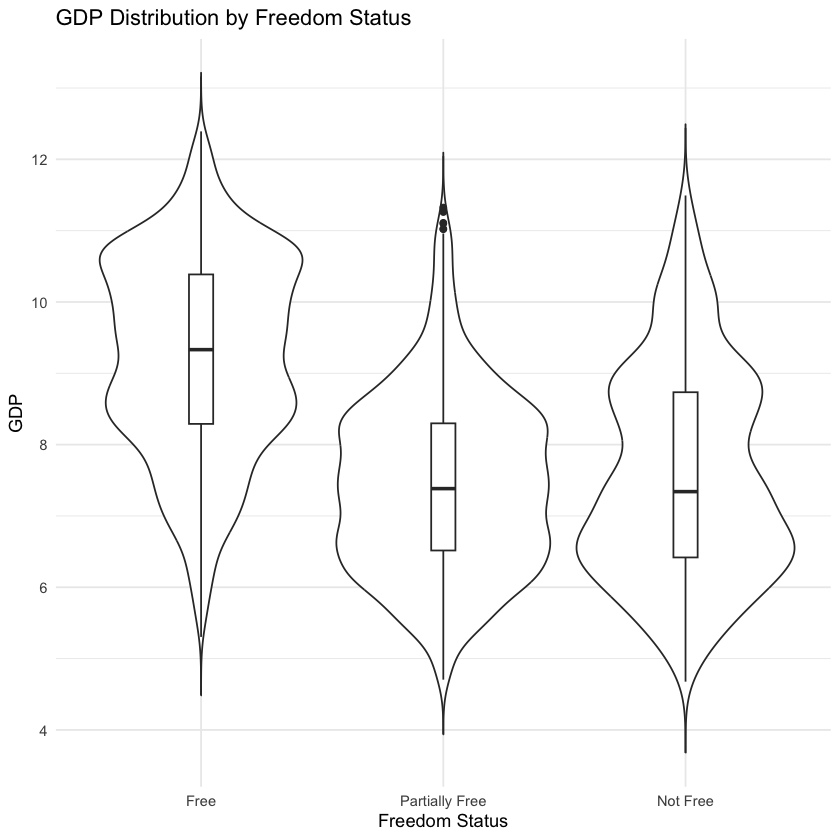

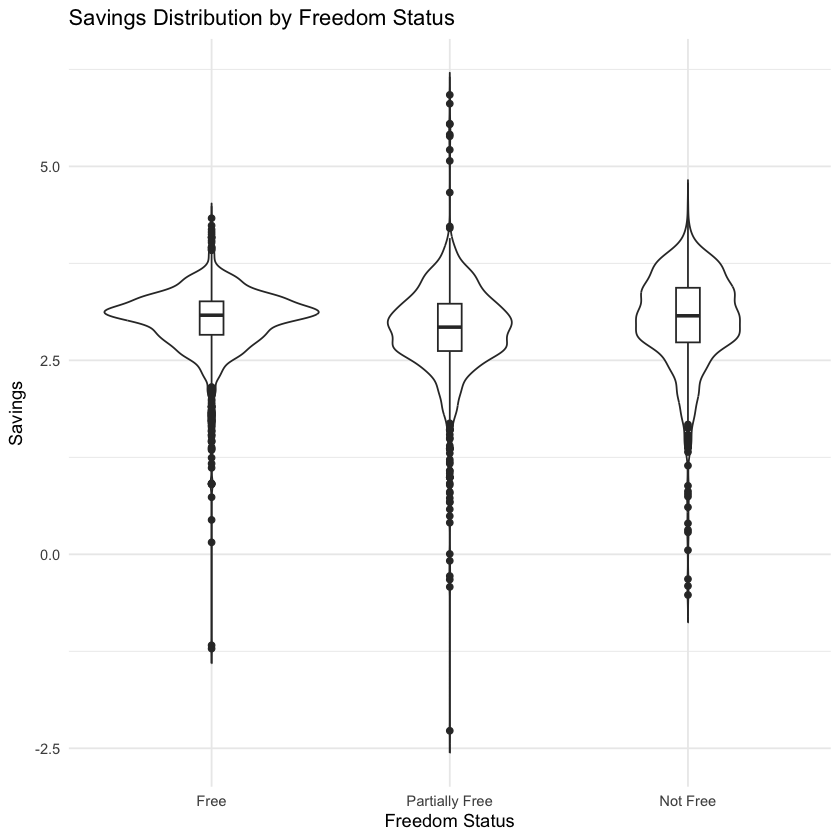

In [23]:
ggplot(data_regression, aes(x = FreedomStatus, y = gdp)) +
  geom_violin(trim = FALSE) +
  geom_boxplot(width = 0.1,
    fill = "white"
  ) +
  theme_minimal() +
  labs(x = "Freedom Status",
    y = "GDP",
    title = "GDP Distribution by Freedom Status"
  )
ggplot(data_regression, aes(x = FreedomStatus, y = saving)) +
  geom_violin(trim = FALSE) +
  geom_boxplot(width = 0.1,
    fill = "white"
  ) +
  theme_minimal() +
  labs(x = "Freedom Status",
    y = "Savings",
    title = "Savings Distribution by Freedom Status"
  )

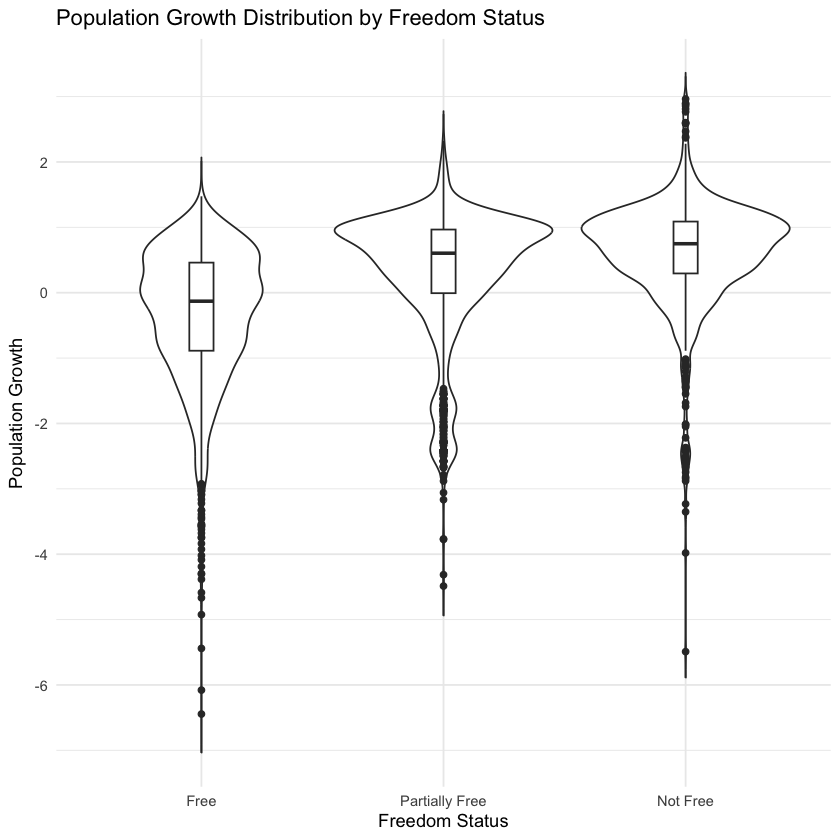

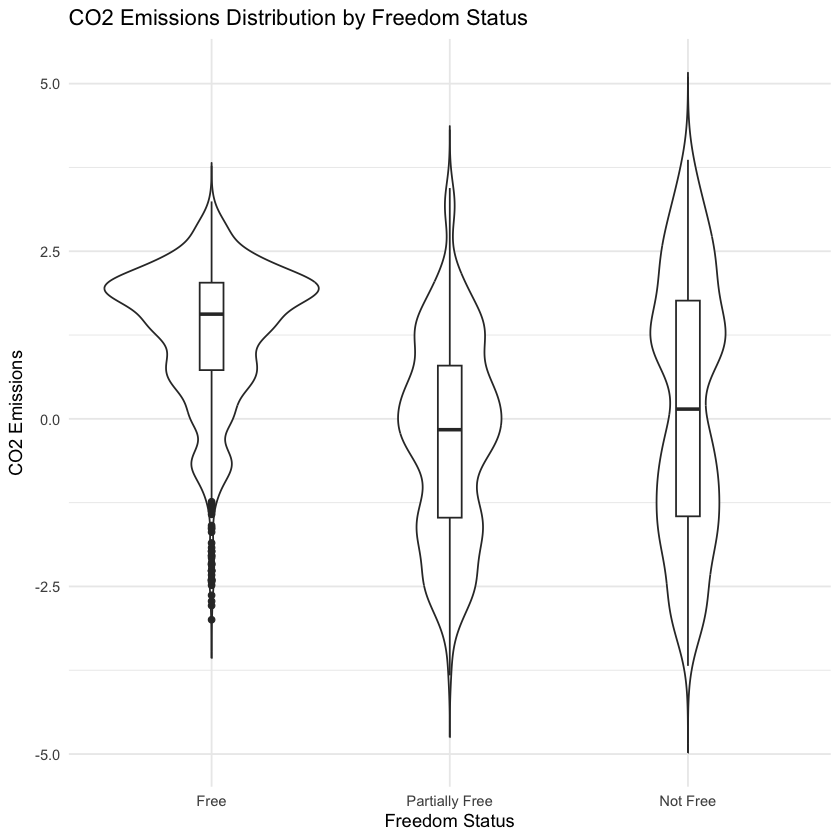

In [24]:
ggplot(data_regression, aes(x = FreedomStatus, y = pop_growth)) +
  geom_violin(trim = FALSE) +
  geom_boxplot(width = 0.1,
    fill = "white"
  ) +
  theme_minimal() +
  labs(x = "Freedom Status", 
    y = "Population Growth", 
    title = "Population Growth Distribution by Freedom Status"
  )
ggplot(data_regression, aes(x = FreedomStatus, y = co2_emission)) +
  geom_violin(trim = FALSE) +
  geom_boxplot(width = 0.1, 
    fill = "white") +
  theme_minimal() +
  labs(x = "Freedom Status",
    y = "CO2 Emissions",
    title = "CO2 Emissions Distribution by Freedom Status"
  )

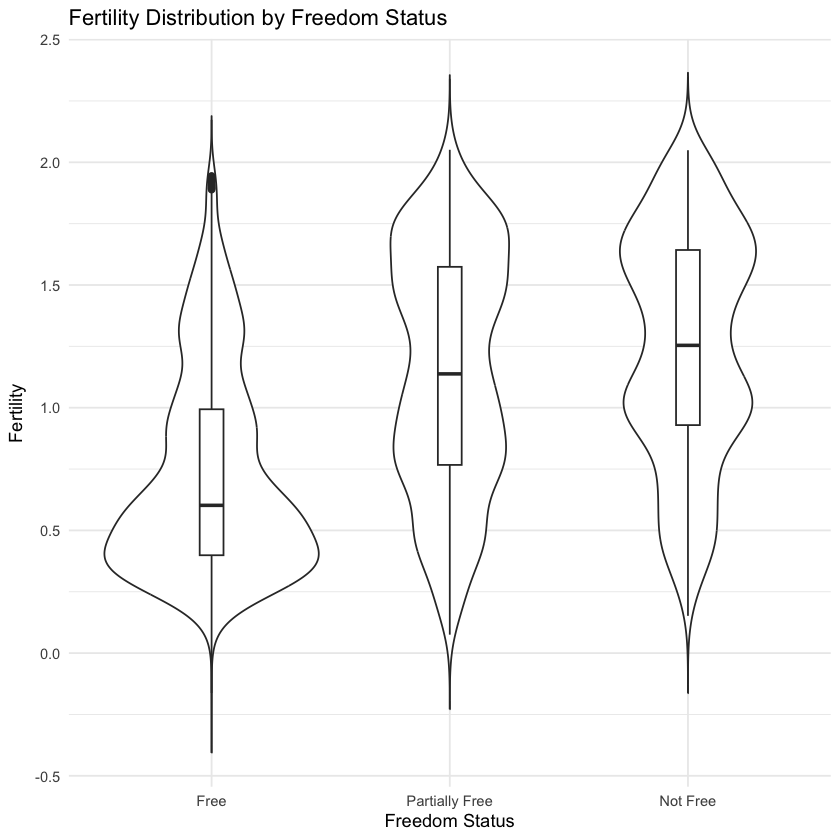

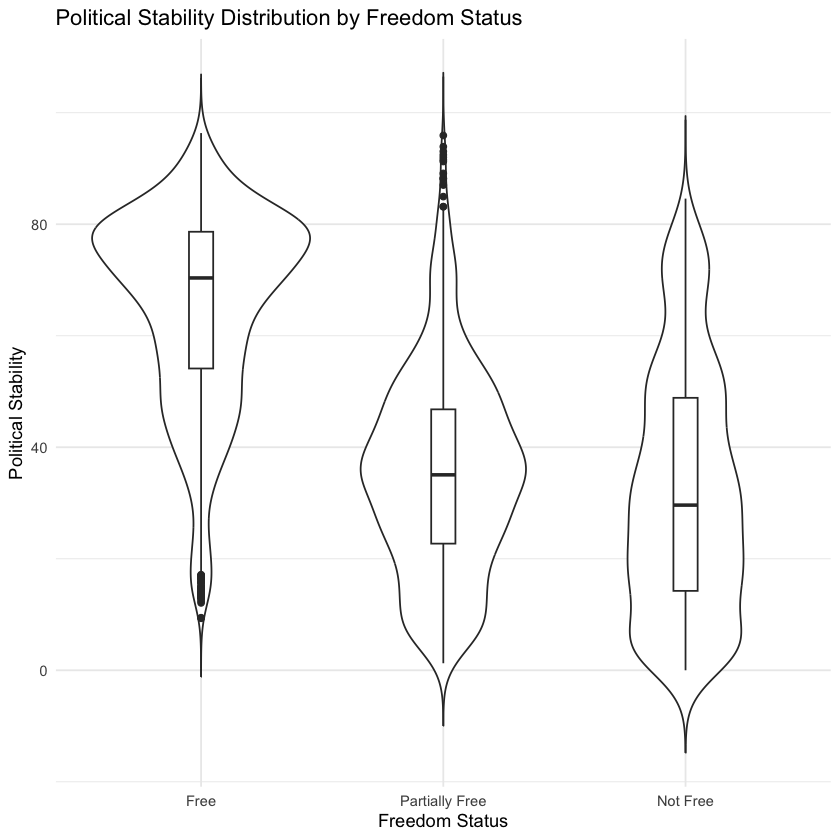

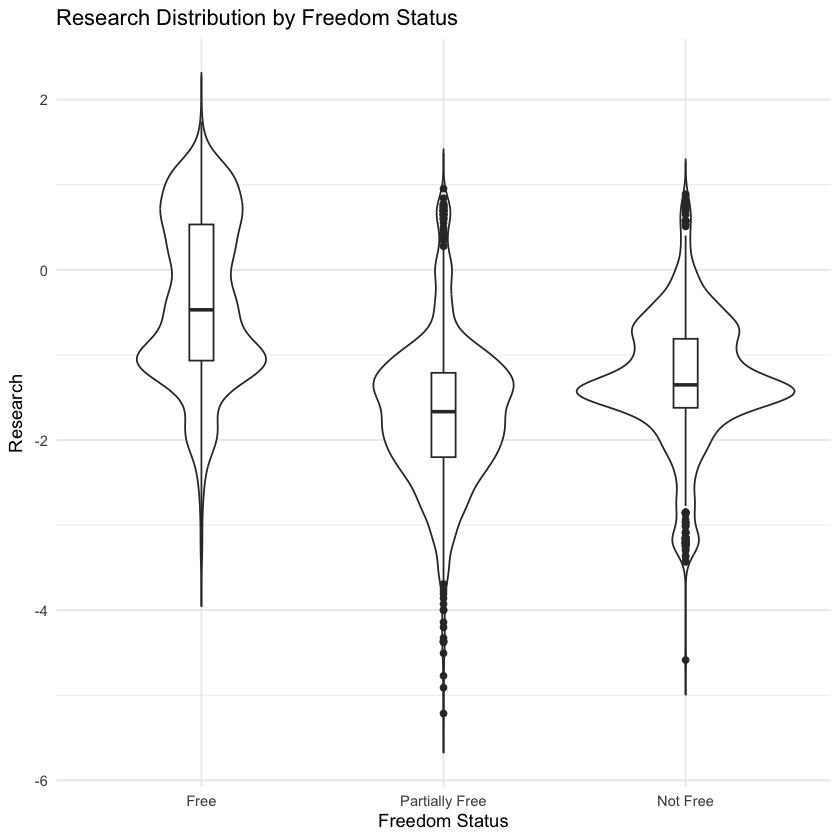

In [25]:
ggplot(data_regression, aes(x = FreedomStatus, y = fertility)) +
  geom_violin(trim = FALSE) +
  geom_boxplot(width = 0.1,
    fill = "white"
  ) +
  theme_minimal() +
  labs(x = "Freedom Status",
    y = "Fertility",
    title = "Fertility Distribution by Freedom Status"
  )
ggplot(data_regression, aes(x = FreedomStatus, y = pol_stability)) +
  geom_violin(trim = FALSE) +
  geom_boxplot(width = 0.1,
    fill = "white"
  ) +
  theme_minimal() +
  labs(x = "Freedom Status",
    y = "Political Stability",
    title = "Political Stability Distribution by Freedom Status"
  )
ggplot(data_regression, aes(x = FreedomStatus, y = research)) +
  geom_violin(trim = FALSE) +
  geom_boxplot(width = 0.1,
    fill = "white"
  ) +
  theme_minimal() +
  labs(x = "Freedom Status",
    y = "Research",
    title = "Research Distribution by Freedom Status"
  )

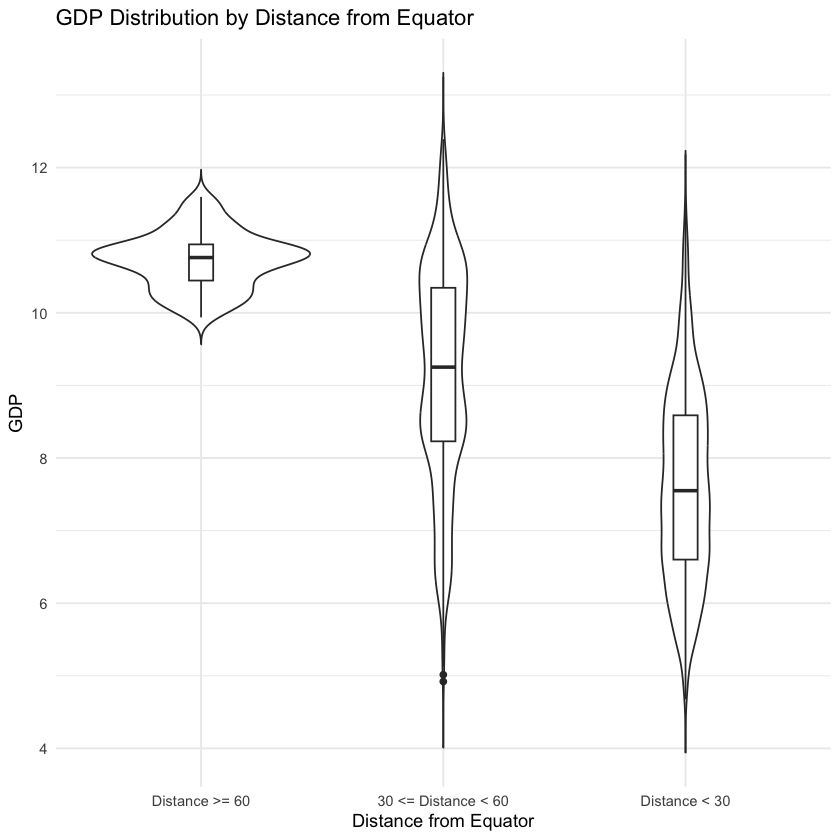

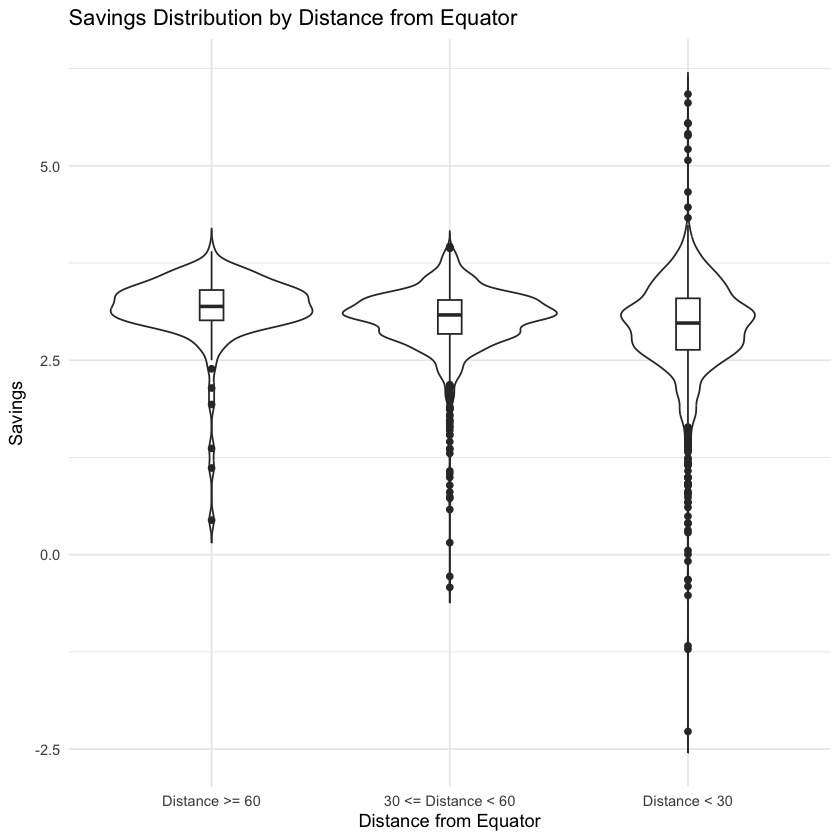

In [26]:
ggplot(data_regression, aes(x = Distance, y = gdp)) +
  geom_violin(trim = FALSE) +
  geom_boxplot(width = 0.1,
               fill = "white"
  ) +
  theme_minimal() +
  labs(x = "Distance from Equator",
       y = "GDP",
       title = "GDP Distribution by Distance from Equator"
  )

ggplot(data_regression, aes(x = Distance, y = saving)) +
  geom_violin(trim = FALSE) +
  geom_boxplot(width = 0.1,
               fill = "white"
  ) +
  theme_minimal() +
  labs(x = "Distance from Equator",
       y = "Savings",
       title = "Savings Distribution by Distance from Equator"
  )


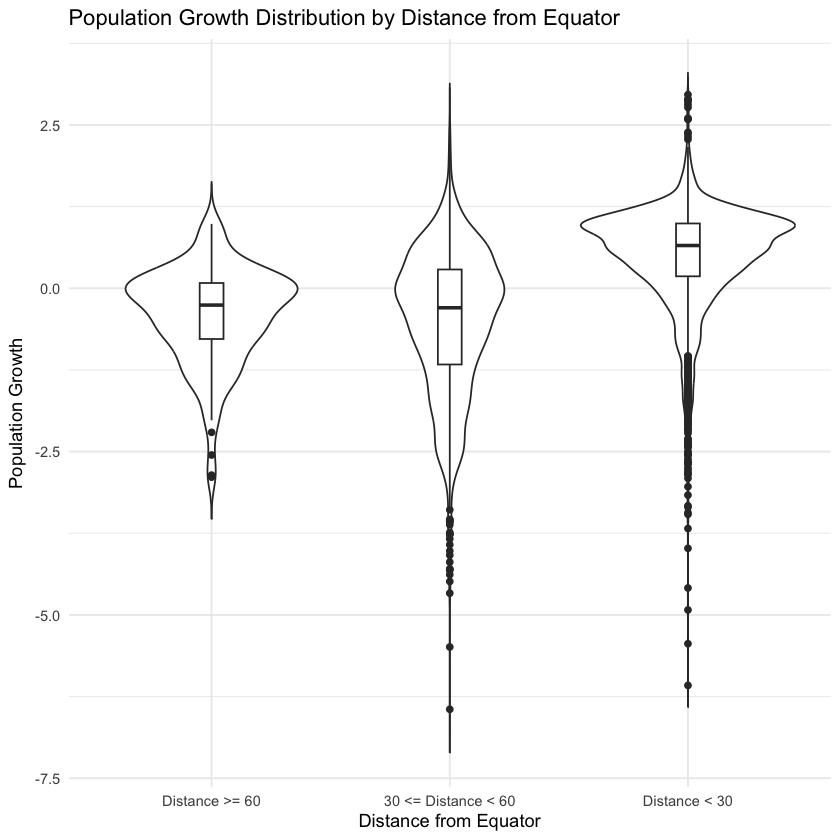

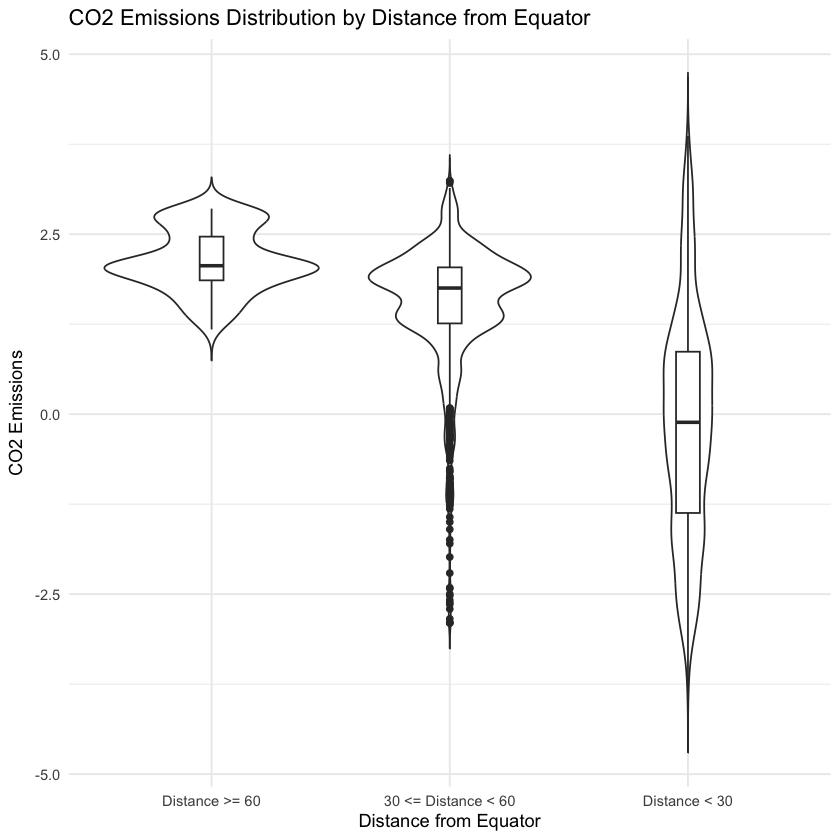

In [27]:
ggplot(data_regression, aes(x = Distance, y = pop_growth)) +
  geom_violin(trim = FALSE) +
  geom_boxplot(width = 0.1,
               fill = "white"
  ) +
  theme_minimal() +
  labs(x = "Distance from Equator", 
       y = "Population Growth", 
       title = "Population Growth Distribution by Distance from Equator"
  )
ggplot(data_regression, aes(x = Distance, y = co2_emission)) +
  geom_violin(trim = FALSE) +
  geom_boxplot(width = 0.1, 
               fill = "white") +
  theme_minimal() +
  labs(x = "Distance from Equator",
       y = "CO2 Emissions",
       title = "CO2 Emissions Distribution by Distance from Equator"
  )

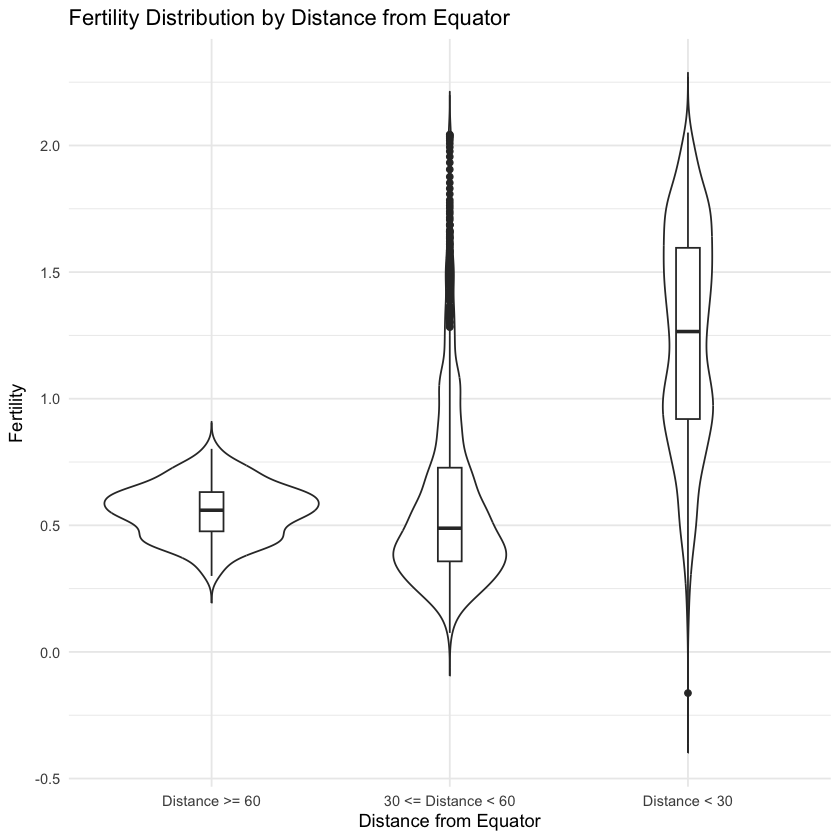

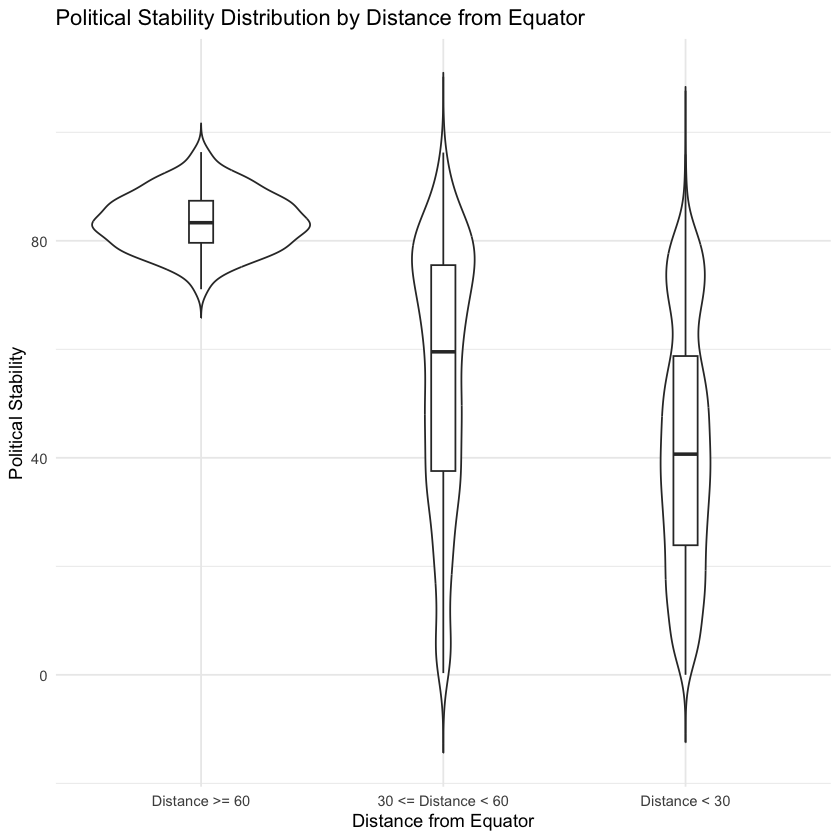

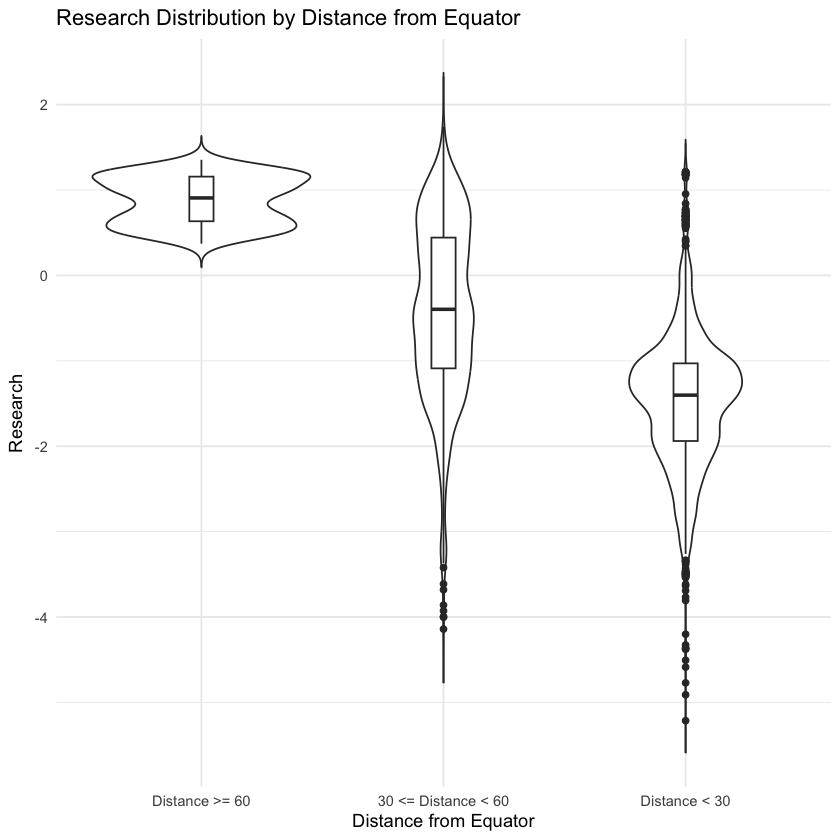

In [28]:
ggplot(data_regression, aes(x = Distance, y = fertility)) +
  geom_violin(trim = FALSE) +
  geom_boxplot(width = 0.1,
               fill = "white"
  ) +
  theme_minimal() +
  labs(x = "Distance from Equator",
       y = "Fertility",
       title = "Fertility Distribution by Distance from Equator"
  )

ggplot(data_regression, aes(x = Distance, y = pol_stability)) +
  geom_violin(trim = FALSE) +
  geom_boxplot(width = 0.1,
               fill = "white"
  ) +
  theme_minimal() +
  labs(x = "Distance from Equator",
       y = "Political Stability",
       title = "Political Stability Distribution by Distance from Equator"
  )

ggplot(data_regression, aes(x = Distance, y = research)) +
  geom_violin(trim = FALSE) +
  geom_boxplot(width = 0.1,
               fill = "white"
  ) +
  theme_minimal() +
  labs(x = "Distance from Equator",
       y = "Research",
       title = "Research Distribution by Distance from Equator"
  )

From these plots we can infer that:
- GDP, CO2 Emissions, Fertility and Corruption have no outliers, have a remarkable variance and are left-skewed, if compared to the other variables
- Research has some outliers and is somewhat left-skewed
- Population growth has a significant number of outliers, with quite less variance than other variables and seems not skewed if outliers are not considered
- Savings have the most amount of outliers, with the least variance and seems to not be skewed
- Dummies affect heavily the distributions of our variables

## Linear Regression

We now do a linear regression.
We start from the model given by the assignment, i.e. $\text{log}(gdp)=\text{log}(savings)+\text{log}(population \,\, growth)$

In [29]:
model <- lm(gdp ~ saving + pop_growth, data = data_regression)

We now check the summary of the model

In [30]:
summary(model)


Call:
lm(formula = gdp ~ saving + pop_growth, data = data_regression)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.4033 -1.0207 -0.1898  0.9567  5.4765 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.38067    0.11555   46.56   <2e-16 ***
saving       0.98910    0.03823   25.87   <2e-16 ***
pop_growth  -0.55795    0.01972  -28.30   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.396 on 4505 degrees of freedom
Multiple R-squared:  0.2517,	Adjusted R-squared:  0.2514 
F-statistic: 757.7 on 2 and 4505 DF,  p-value: < 2.2e-16


As the residuals are very spread out we check that there's no outliers by running the Breusch-Pagan test.
The Breusch-Pagan test for homoscedasticity is designed to assess the presence of heteroscedasticity in a regression model. The null hypothesis ($H_0$) of the test is that the variance of the errors ($σ_i^2$) is constant across observations, implying homoscedasticity ($σ_i^2 = σ^2$). The alternative hypothesis ($H_1$) suggests the existence of a relationship between the variance of the errors and one or more explanatory variables ($σ_i^2 = f(γ + δZ)$), where $Z$ could be any subset of the explanatory variables in the model, their transformations, or even different variables not included in the regression model.

In [31]:
bptest(model)


	studentized Breusch-Pagan test

data:  model
BP = 125.53, df = 2, p-value < 2.2e-16


As the null hypothesis is rejected, we plot the modelto understand what may be causing the problem

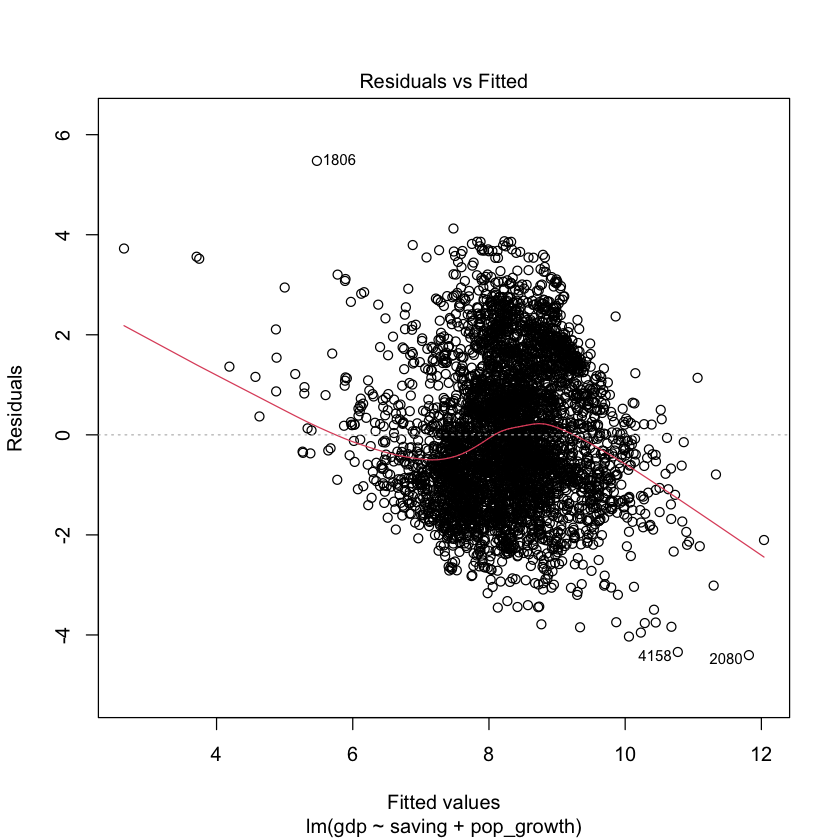

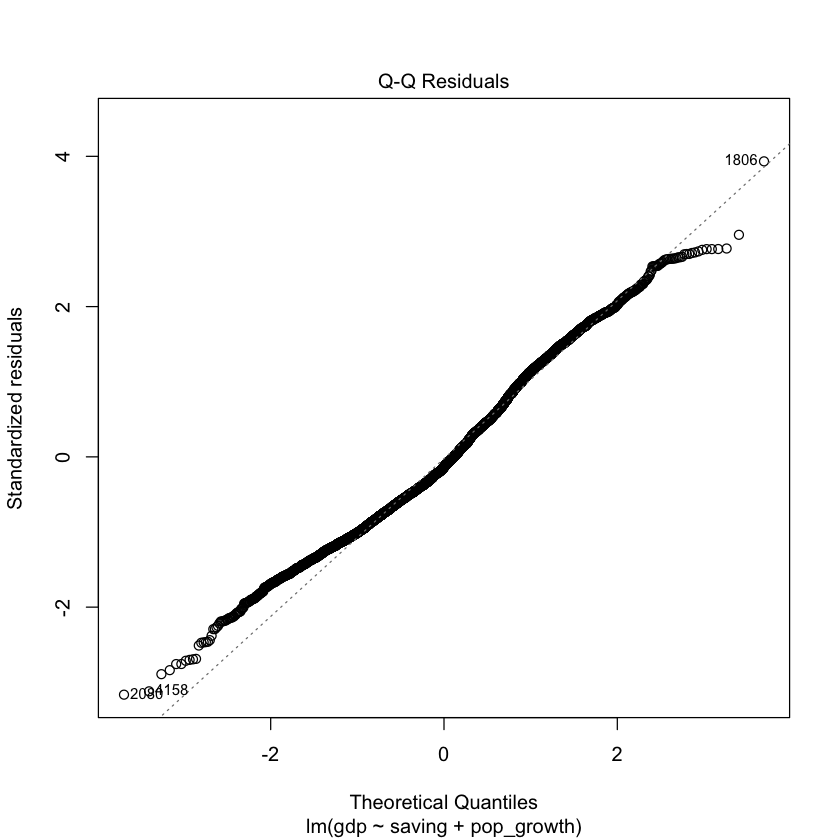

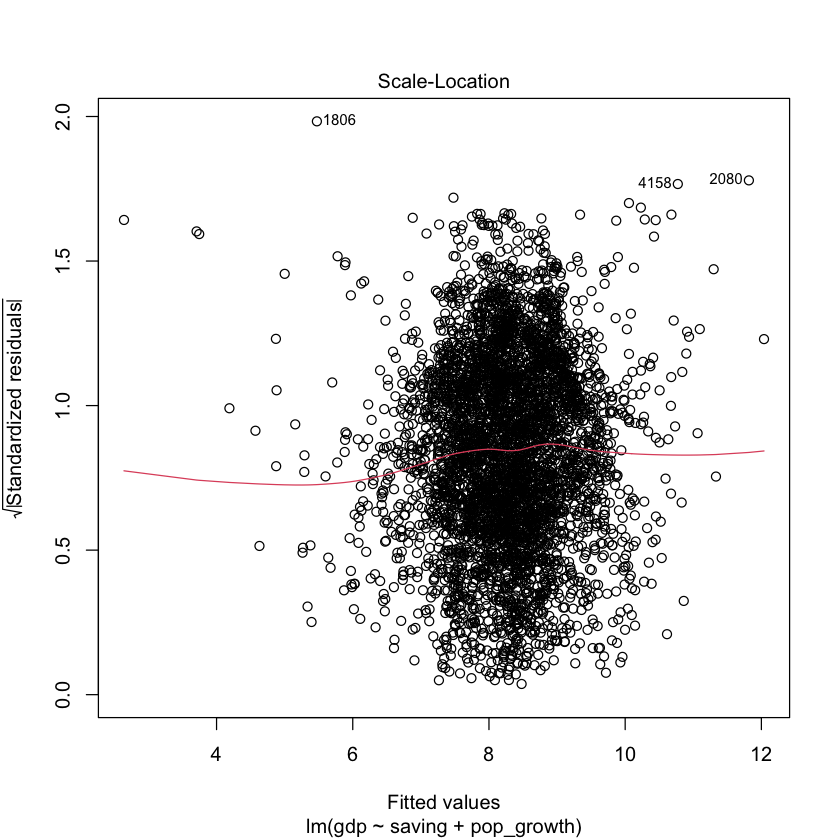

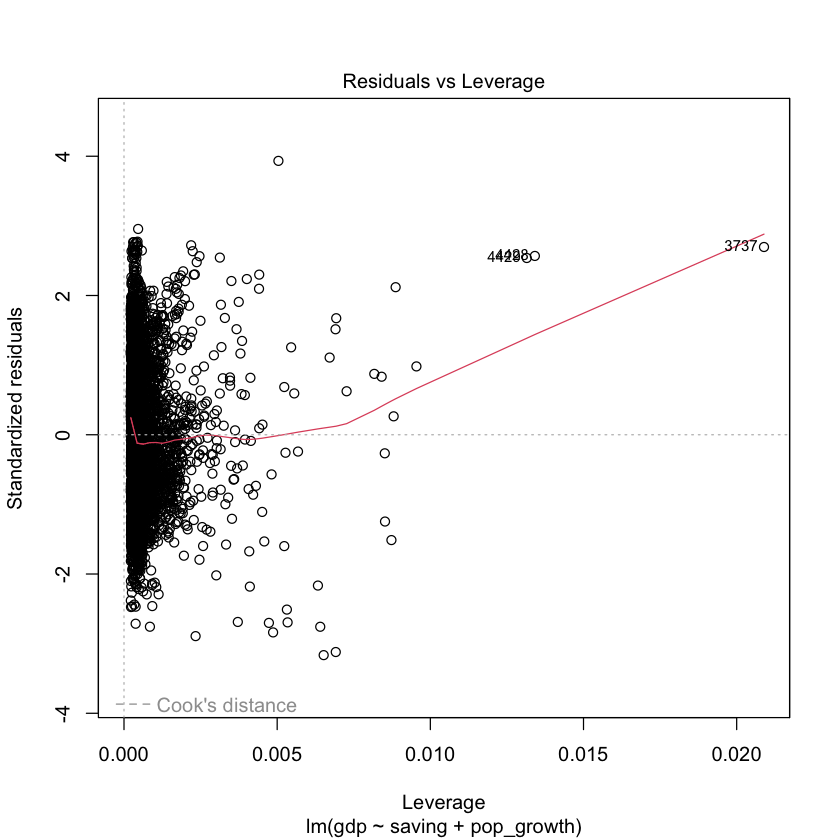

In [32]:
plot(model)

The spread observed in both the `Residuals vs Fitted`plot and `Scale Location`plot follow what we observed in the scatter plot of `GDP and Savings`. 

For this reason we change the model to 

$\text{log}(gdp)=\text{log}(co2 \,\,emissions)+\text{log}(fertility)+corruption+\text{log}(research)+\text{log}(population \,\, growth)$

Accounting for the dummy variables created

In [33]:
model <- lm(gdp ~ co2_emission + fertility + pol_stability + research + pop_growth + dummy_F + dummy_PF + dummy_60_plus + dummy_30_60, data = data_regression)

Now we check the summary of the model and run again the BP Test

In [34]:
summary(model)
bptest(model)


Call:
lm(formula = gdp ~ co2_emission + fertility + pol_stability + 
    research + pop_growth + dummy_F + dummy_PF + dummy_60_plus + 
    dummy_30_60, data = data_regression)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.1681 -0.4047  0.0662  0.4601  3.3950 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    8.3503332  0.0677577 123.238  < 2e-16 ***
co2_emission   0.5379689  0.0119790  44.909  < 2e-16 ***
fertility     -0.6604054  0.0450969 -14.644  < 2e-16 ***
pol_stability  0.0085936  0.0006652  12.919  < 2e-16 ***
research       0.2851603  0.0149724  19.046  < 2e-16 ***
pop_growth     0.1404303  0.0143011   9.820  < 2e-16 ***
dummy_F        0.3218108  0.0360009   8.939  < 2e-16 ***
dummy_PF       0.1571861  0.0322934   4.867 1.17e-06 ***
dummy_60_plus  0.3663217  0.0718106   5.101 3.51e-07 ***
dummy_30_60   -0.1595034  0.0309982  -5.146 2.78e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard e


	studentized Breusch-Pagan test

data:  model
BP = 283.92, df = 9, p-value < 2.2e-16


The null hypothesis is still rejected, however all chosen parameters are statistically significant, and the residuals are less spread out. We once again plot the residuals to check what the problem might be

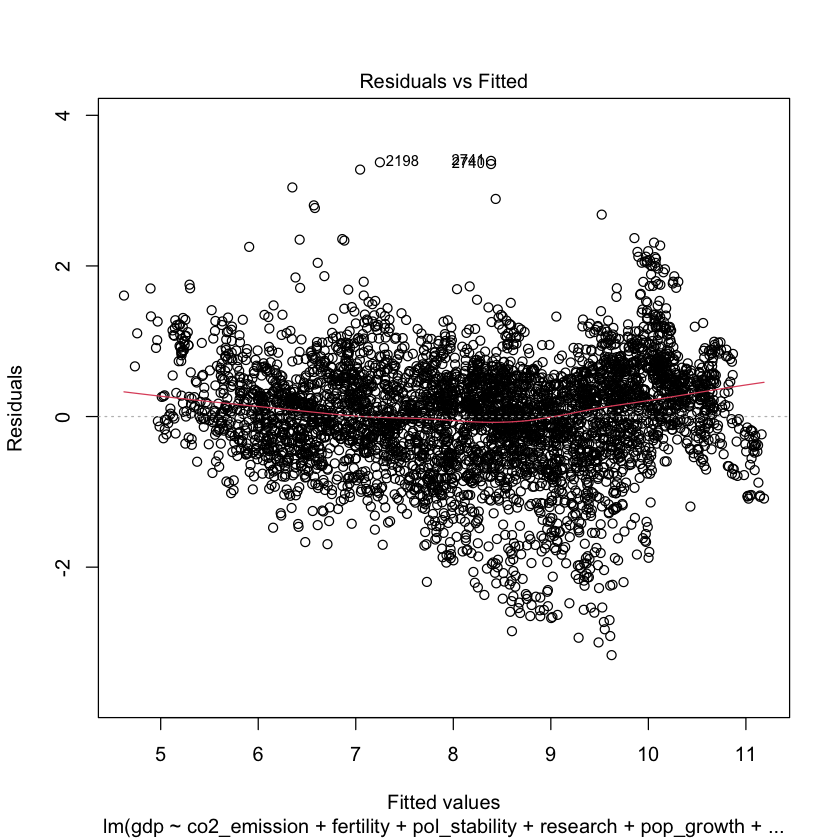

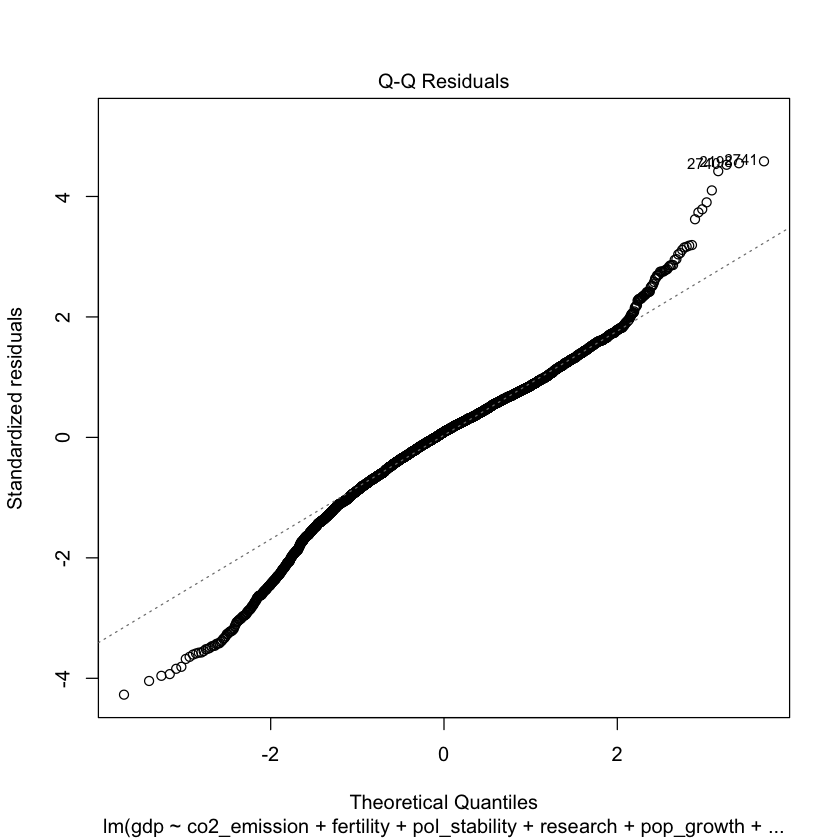

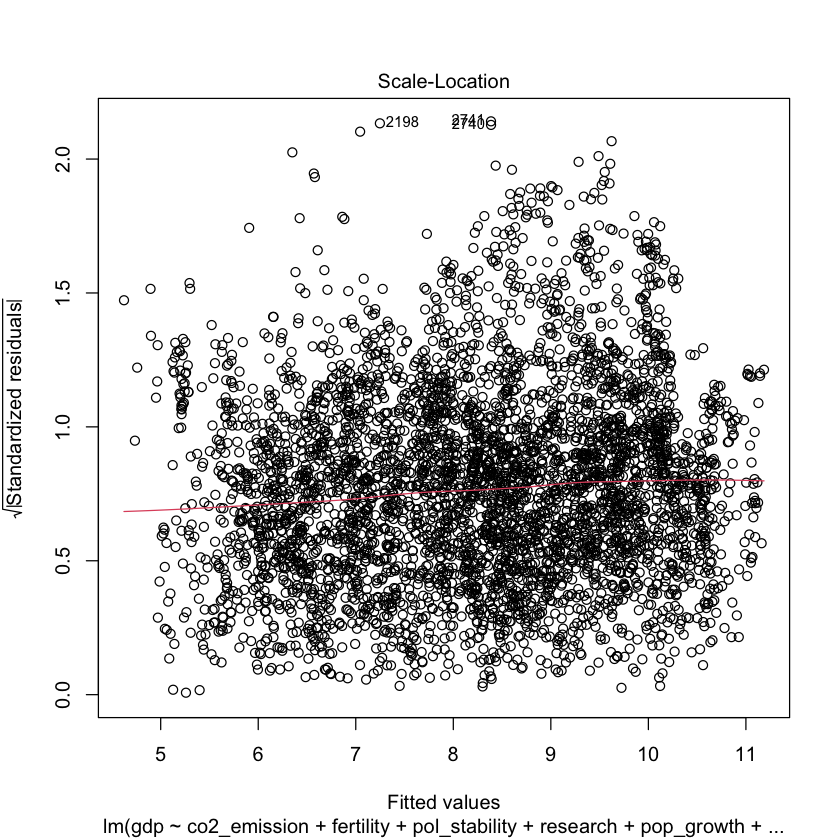

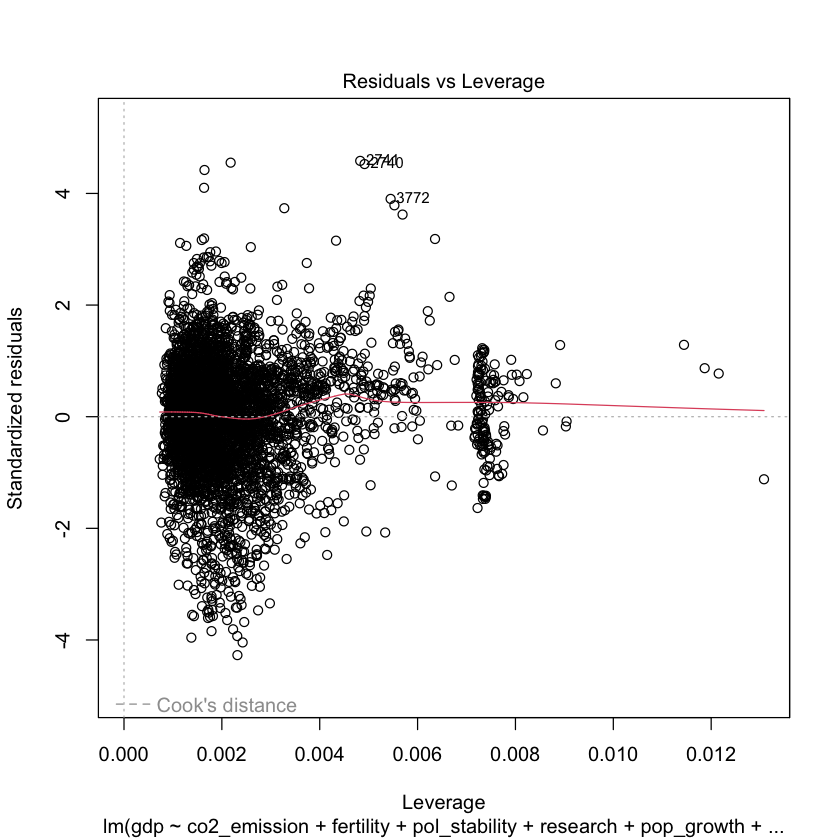

In [35]:
plot(model)

From the `Residuals vs Fitted` we can see that there's a slight correlation and from the `Q-Q plot` we can see that the residuals diverge from a normal distribution. 

As we fear that there may be some autocorrelation between the errors, we check the plot of the ACF (autocorrelation function) and PACF (partial autocorrelation function)

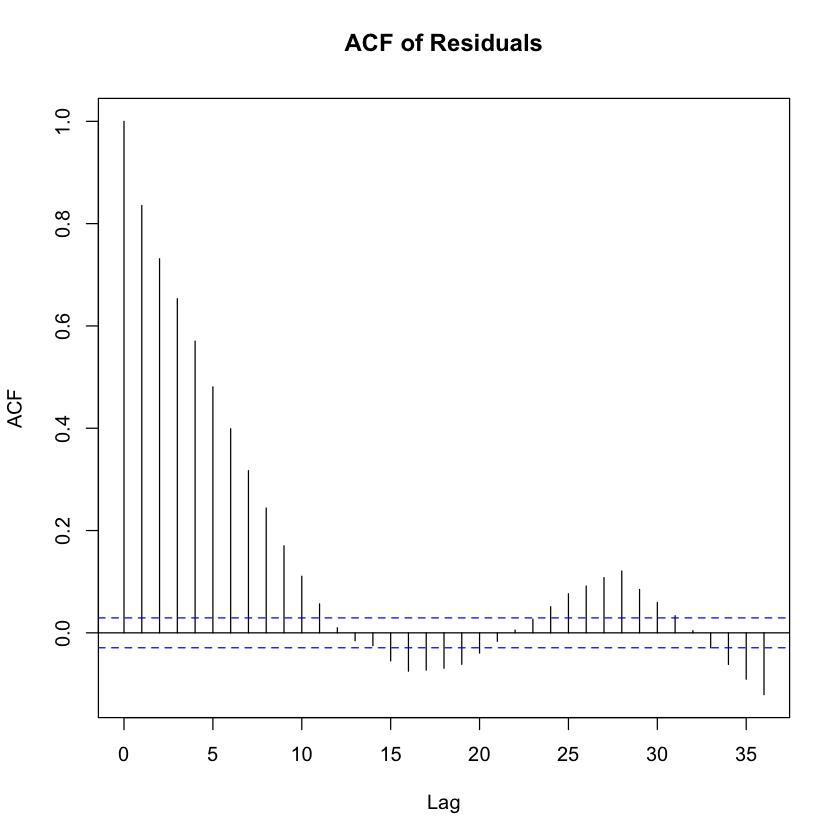

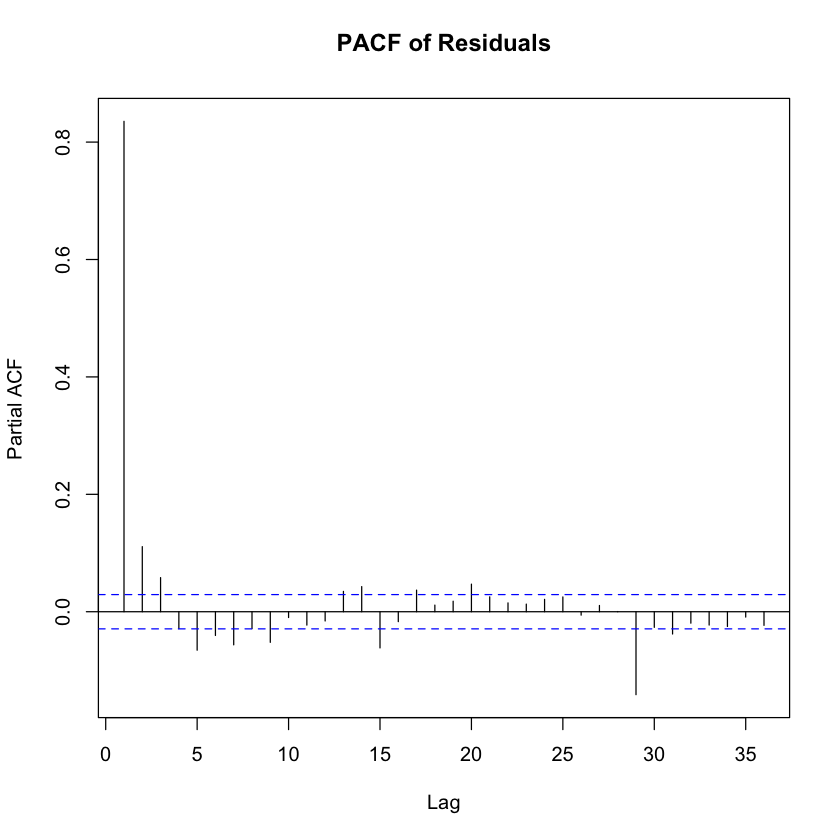

In [36]:
residuals <- residuals(model)
acf(residuals, main="ACF of Residuals")
pacf(residuals, main="PACF of Residuals")

As there seems to be significant correlation, we now move to use the Ljung-Box Q-test to check for autocorrelation in the residuals at different lags collectively, not just individually.

In [37]:
Box.test(residuals, type = "Ljung-Box")


	Box-Ljung test

data:  residuals
X-squared = 3148, df = 1, p-value < 2.2e-16


As the p-value is close to 0, we reject the hypothesis that there's no autocorrelation. For this reason we decided it was best to move away from an OLS model.

## Generalised Least Squared Model

As the model with new predictors is still heteroskedastic, due to autocorrelation, we decided it was best to use a Generalized Least Squares model. Unlike OLS, GLS acknowledges that the variance of the error terms may not be constant (heteroscedasticity) or that errors may be correlated over time or across observations (autocorrelation). To address these issues, GLS transforms the original model using a provided variance-covariance matrix of the errors, leading to accurate and unbiased estimators even in the presence of heteroscedasticity. This approach involves pre-multiplying the model by the inverse square root of the variance-covariance matrix to produce homoscedastic and uncorrelated error terms, allowing the application of OLS to this transformed model. The transformed model's estimators, obtained through OLS, are the GLS estimators for the original model, providing more reliable coefficient estimates under the specific violations of OLS assumptions.

As there is autocorrelation within the model, we decided to use an autoregressive of order 1 correlation structure (`corAR1`). The intuition is that each observation is correlated to its preceding observation, implying that the current value can be partly predicted by its immediate past value. Mathematically, the variance-covariance matrix $\Sigma$ can be seen as:

$\Sigma=(X^TW^{-1}X)^{-1}X^TW^{-1}VW^{-1}X(X^TW^{-1}X)^{-1}$ 

Where: 
- $X$ is the matrix of independent variables, so in our case intercept, corruption, co2 emission, research, fertility and population growth
- $W$ is a diagonal weight matrix used to account for heteroscedasticity, in this case $W = \sigma^2\cdot I$
- $V$ represents the covariance matrix that models the correlation between the observations. For `corAR1`, this correlation is modeled as decaying exponentially with the distance between observations, which is parameterized by the correlation coefficient $\rho$. Mathematically:

    $\rho(y_i, y_j) = \rho^{|i-j|}$



In [38]:
gls_model <- gls(gdp ~ pol_stability + co2_emission + research + fertility + pop_growth + dummy_F + dummy_PF + dummy_30_60 + dummy_60_plus, 
  data = data_regression,
  corr = corAR1(),
  control = glsControl(
    maxIter = 1000,
    msMaxIter = 100,
    returnObject = TRUE,
    tolerance = 1e-6,
    msTol = 1e-6
    ),
  verbose = TRUE
)

We now check the summary of the model

In [39]:
summary(gls_model)

Generalized least squares fit by REML
  Model: gdp ~ pol_stability + co2_emission + research + fertility + pop_growth +      dummy_F + dummy_PF + dummy_30_60 + dummy_60_plus 
  Data: data_regression 
       AIC      BIC    logLik
  3570.465 3647.401 -1773.232

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.9144551 

Coefficients:
                  Value  Std.Error   t-value p-value
(Intercept)    9.216946 0.09928995  92.82860  0.0000
pol_stability  0.004938 0.00058547   8.43428  0.0000
co2_emission   0.224587 0.01279419  17.55381  0.0000
research       0.058513 0.01105590   5.29245  0.0000
fertility     -1.329224 0.05232644 -25.40253  0.0000
pop_growth     0.002456 0.01034193   0.23749  0.8123
dummy_F        0.251617 0.04208140   5.97929  0.0000
dummy_PF       0.023927 0.03201914   0.74727  0.4549
dummy_30_60   -0.205493 0.05258678  -3.90769  0.0001
dummy_60_plus  0.789015 0.12016880   6.56589  0.0000

 Correlation: 
              (Intr) pl_stb c2_mss r

How to interpret the output:
- Generalized least squares fit by REML" - The model was fitted using the Restricted Maximum Likelihood method
- "Model" - The model used
- "AIC" - Akaike Information Criterion, a measure of the model quality that balances model fit and complexity. Lower values are better.
- "BIC" - Bayesian Information Criterion, similar to AIC but with a stronger penalty for model complexity. Lower values are better.
- "logLik" - The log-likelihood of the model, a measure of how well the model fits the data. Higher values are better.
- "Correlation Structure": type of correlation used.
- Parameter estimate(s) - range: The estimated range parameter for the correlation structure.
- "Coefficients" - Same as simple lm except that the indicators of significance aren't present
- "Correlation" - Shows the correlation between the predictors
- "Standardized residuals" - The residuals of the model, which are the differences between the observed and predicted values of the dependent variable, standardized by the standard deviation of the residuals. These are used to check for outliers and to assess the model's assumptions.
- "Residual standard error" - The standard deviation of the residuals, a measure of the model's accuracy. Lower values are better.
- "Degrees of freedom" - The number of observations minus the number of parameters in the model


To check if we have removed the problem of heteroskedasticity, we will plot the residuals of the model, as the Breusch-Pagan Test is not available for GLS models

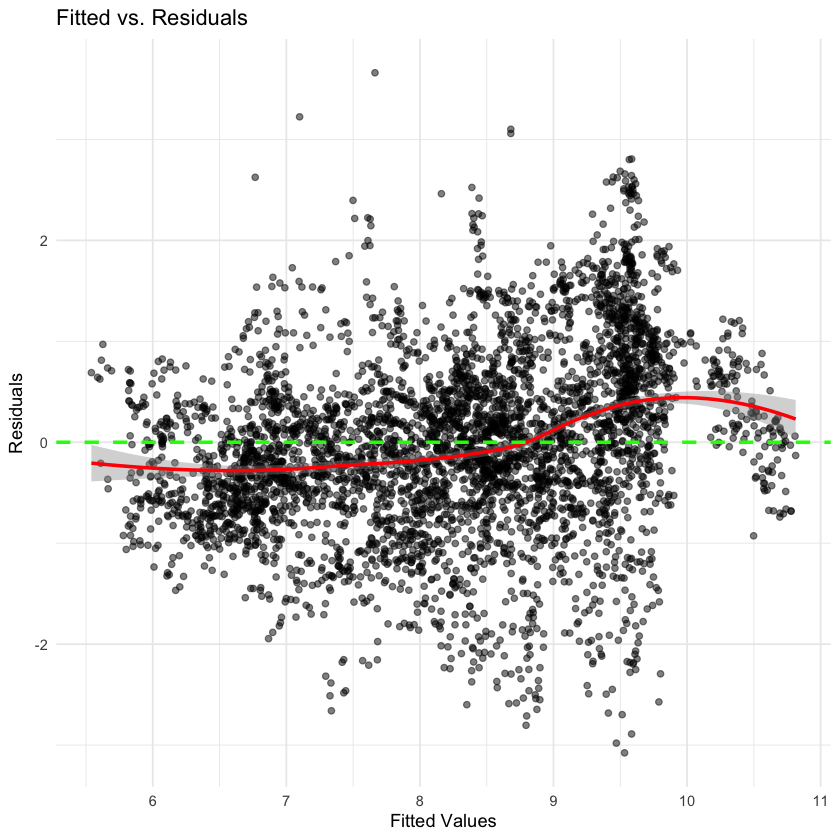

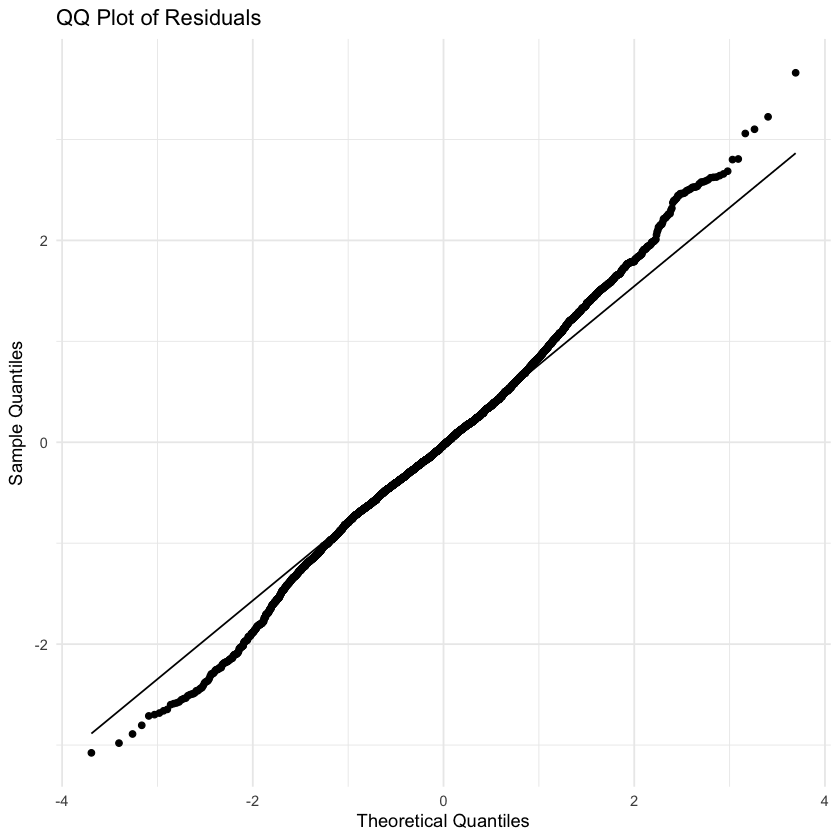

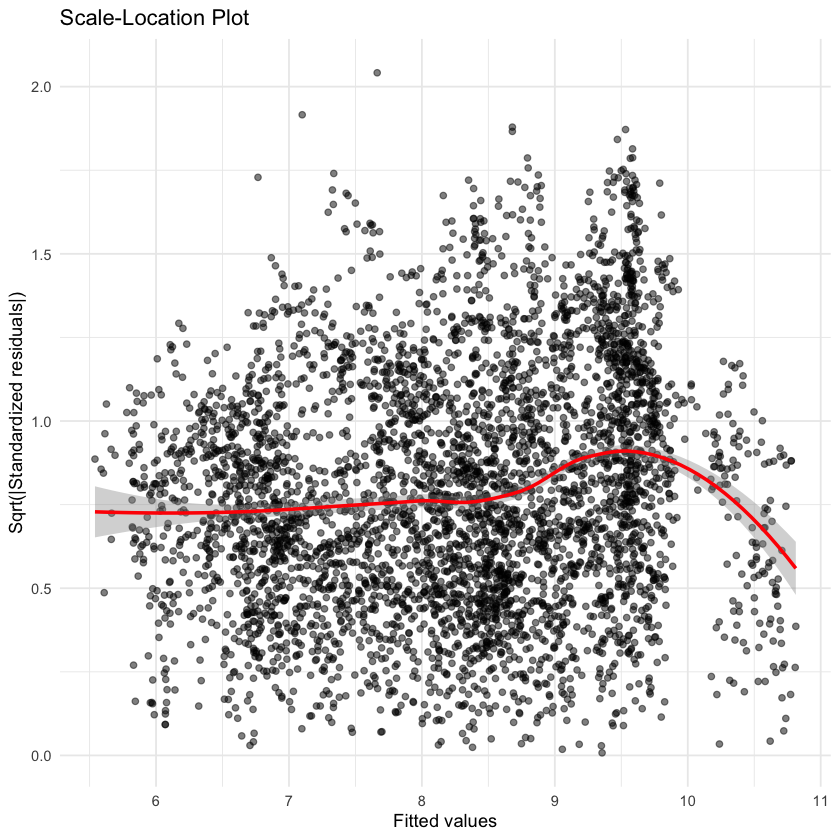

In [40]:
data_for_ggplot <- data.frame(
  Fitted = fitted(gls_model),
  Residuals = residuals(gls_model)
)
ggplot(data_for_ggplot, aes(x = Fitted, y = Residuals)) +
  geom_point(alpha = 0.5) + 
  geom_smooth(aes(y = Residuals), method = "loess", formula = 'y ~ x', color = "red") + 
  geom_hline(yintercept = 0, color = "green", linetype = "dashed", size = 1) +
  labs(x = "Fitted Values", y = "Residuals", title = "Fitted vs. Residuals") +
  theme_minimal()
ggplot(mapping = aes(sample = residuals(gls_model))) +
  stat_qq() +
  stat_qq_line() +
  labs(title = "QQ Plot of Residuals", x = "Theoretical Quantiles", y = "Sample Quantiles") +
  theme_minimal()
std_resid <- resid(gls_model, type = "pearson") / sd(resid(gls_model, type = "pearson"))
data_for_plot <- data.frame(
  Fitted = fitted(gls_model),
  SqrtAbsStdResid = sqrt(abs(std_resid))
)
ggplot(data_for_plot, aes(x = Fitted, y = SqrtAbsStdResid)) +
  geom_point(alpha = 0.5) + 
  geom_smooth(aes(y = SqrtAbsStdResid), method = "loess", formula = 'y ~ x', color = "red") + 
  labs(x = "Fitted values", y = "Sqrt(|Standardized residuals|)", title = "Scale-Location Plot") +
  theme_minimal()


The model is quite better than the OLS one, with quite a lot of improvement on the distribution of the errors, although there's some amount of heteroskedasticity not explained by the current model, with errors following a rather unusual patterns, as demonstrated by the Scale-Location plot and the Fitted against Residual Plot. For this reason, we check whether our model is able to catch all the autocorrelation we observed in the OLS model.

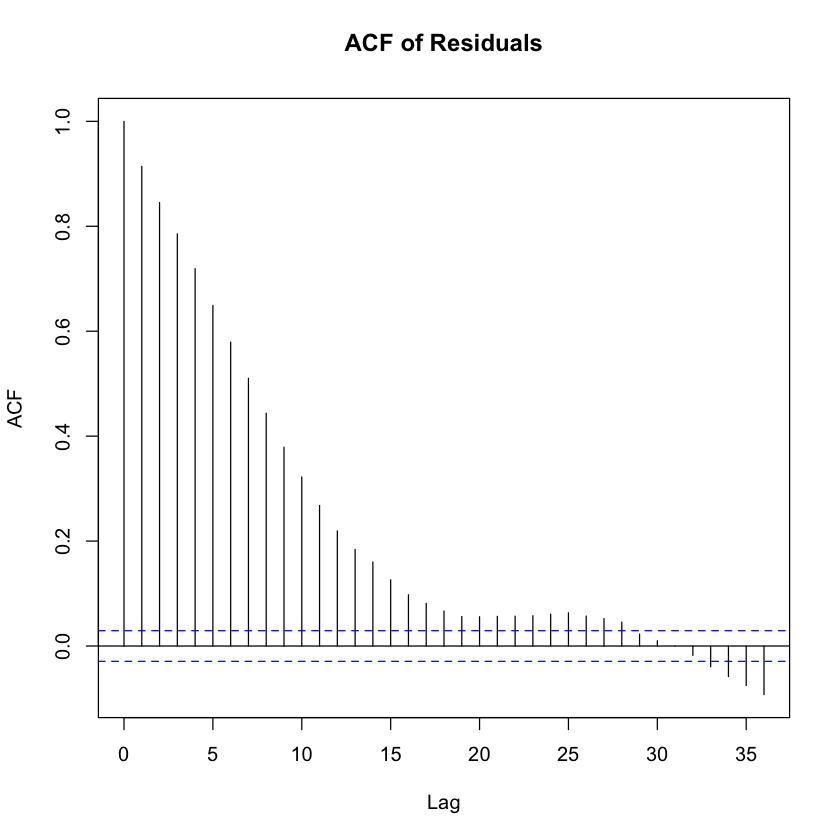

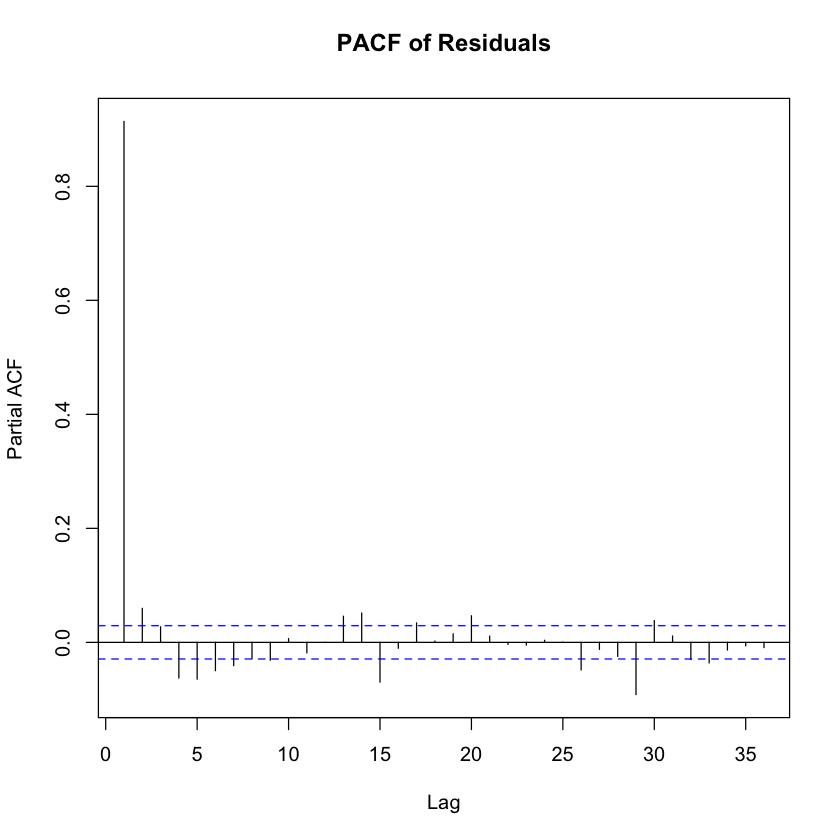

In [41]:
residuals <- residuals(gls_model)
acf(residuals, main="ACF of Residuals")
pacf(residuals, main="PACF of Residuals")

In [42]:
Box.test(residuals, type = "Ljung-Box")


	Box-Ljung test

data:  residuals
X-squared = 3768.5, df = 1, p-value < 2.2e-16


From the Box-Ljung test, it is clear that we need a better model. From the summary, we can see that population growth and the dummy variable for the Partially Free countries are not significant, we will drop them. 

Furthermore, as there seems to be a correlation between fertility, CO2 Emissions and the dummy for countries between 30 and 60 degrees of latitude from the equator, we will decorrelate them, using as a predictor the residuals of the following model:
$fertility = \beta_0 +\beta_1 \cdot Dummy\,\,for\,\,distance\,\,from\,\,equator + \beta_2 \cdot CO2\,\,Emission$

In [43]:
decorr_model <- lm(fertility ~ dummy_30_60, data = data_regression)
data_regression$decorr_fertility <- residuals(decorr_model)

We now try to fit another GLS model, this time trying to also model the variance of the error terms changes as a power function of the fitted values.
Mathematically: $W_{i,i} = |\hat{y_i}|^\theta$
Where $\hat{y_i}$ is the fitted value of the $i$th observation and $\theta$ is estimated by the model

In [44]:
gls_model_2 <- gls(gdp ~ pol_stability + co2_emission + research + dummy_F + dummy_30_60 + dummy_60_plus + decorr_fertility, 
  data = data_regression,
  corr = corAR1(),
  weights = varPower(form = ~fitted(.)),
  control = glsControl(
    maxIter = 1000,
    msMaxIter = 100,
    returnObject = TRUE,
    tolerance = 1e-6,
    msTol = 1e-6
  ),
  verbose = TRUE
)


Iteration: 1
Objective: NULL 
corStruct  parameters:
[1] 3.099993
varStruct  parameters:
    power 
0.1345264 

Convergence:
     beta corStruct varStruct 
 3.925354  1.000000  1.000000 

Iteration: 2
Objective: NULL 
corStruct  parameters:
[1] 3.108423
varStruct  parameters:
      power 
0.004205072 

Convergence:
       beta   corStruct   varStruct 
 0.03768884  0.00271205 30.99145352 

Iteration: 3
Objective: NULL 
corStruct  parameters:
[1] 3.107909
varStruct  parameters:
     power 
0.01093688 

Convergence:
        beta    corStruct    varStruct 
0.0014420982 0.0001652669 0.6155145950 

Iteration: 4
Objective: NULL 
corStruct  parameters:
[1] 3.107933
varStruct  parameters:
     power 
0.01070003 

Convergence:
        beta    corStruct    varStruct 
4.916121e-05 7.695271e-06 2.213586e-02 

Iteration: 5
Objective: NULL 
corStruct  parameters:
[1] 3.107933
varStruct  parameters:
     power 
0.01070003 

Convergence:
        beta    corStruct    varStruct 
4.493223e-08 0.000000e+0

We once again check the summary, and plot the residuals to check whether heteroskedasticity is still present

In [45]:
summary(gls_model_2)

Generalized least squares fit by REML
  Model: gdp ~ pol_stability + co2_emission + research + dummy_F + dummy_30_60 +      dummy_60_plus + decorr_fertility 
  Data: data_regression 
      AIC     BIC    logLik
  3556.71 3627.24 -1767.355

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.9144376 
Variance function:
 Structure: Power of variance covariate
 Formula: ~fitted(.) 
 Parameter estimates:
     power 
0.01070003 

Coefficients:
                     Value  Std.Error   t-value p-value
(Intercept)       7.625110 0.07152831 106.60268       0
pol_stability     0.004958 0.00058248   8.51209       0
co2_emission      0.223814 0.01270575  17.61518       0
research          0.057313 0.01095593   5.23123       0
dummy_F           0.233378 0.03437766   6.78864       0
dummy_30_60       0.605066 0.04771397  12.68111       0
dummy_60_plus     0.792647 0.12031889   6.58788       0
decorr_fertility -1.331481 0.05073539 -26.24363       0

 Correlation: 
         

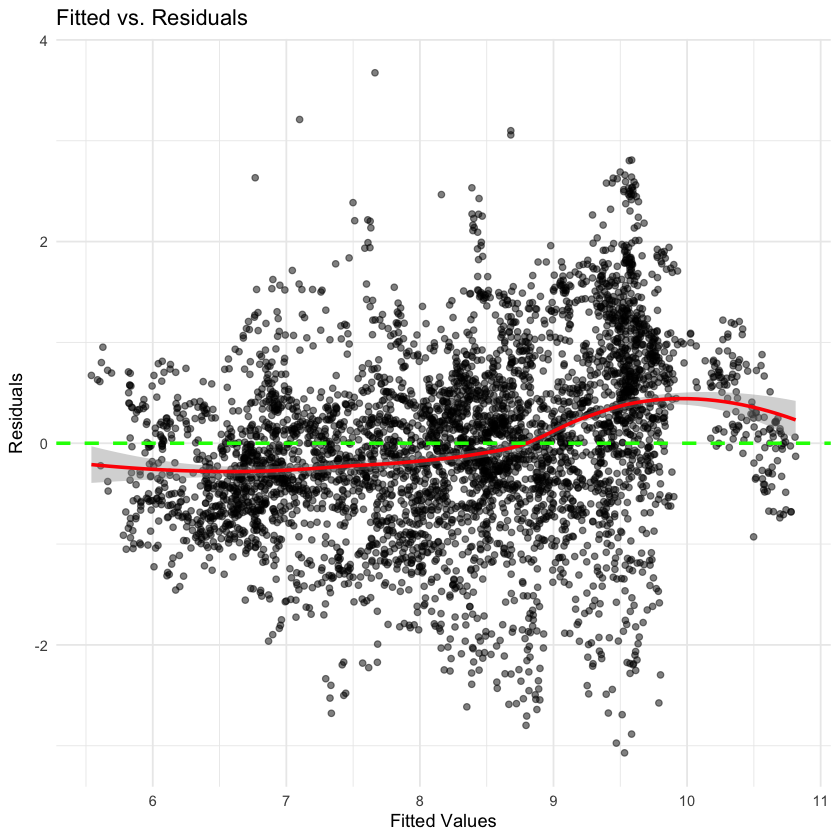

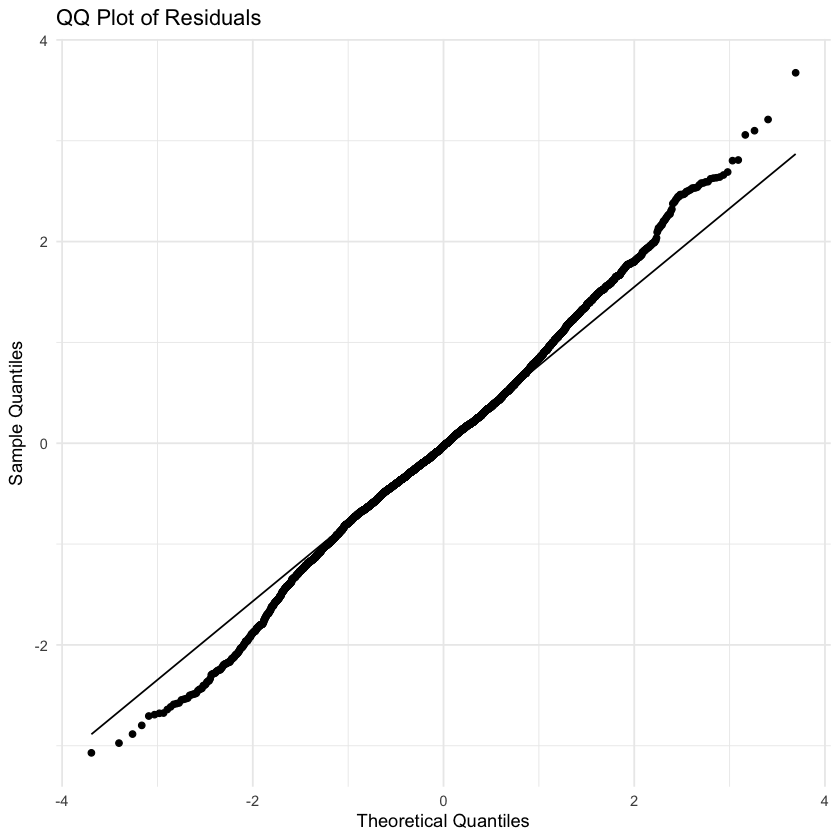

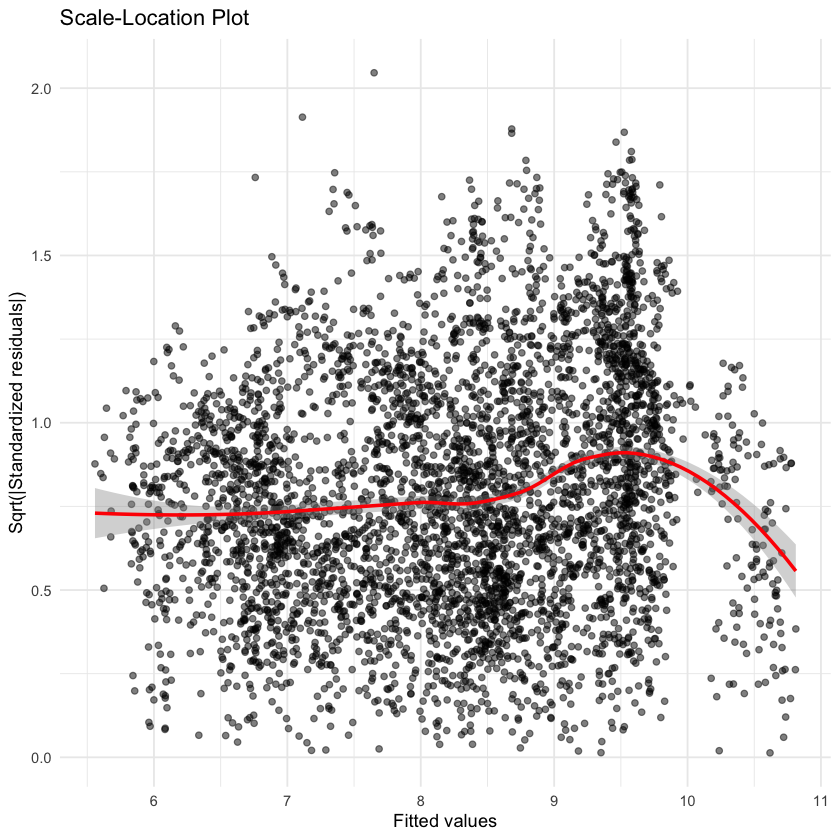

In [46]:
data_for_ggplot <- data.frame(
  Fitted = fitted(gls_model),
  Residuals = residuals(gls_model_2)
)
ggplot(data_for_ggplot, aes(x = Fitted, y = Residuals)) +
  geom_point(alpha = 0.5) + 
  geom_smooth(aes(y = Residuals), method = "loess", formula = 'y ~ x', color = "red") + 
  geom_hline(yintercept = 0, color = "green", linetype = "dashed", size = 1) +
  labs(x = "Fitted Values", y = "Residuals", title = "Fitted vs. Residuals") +
  theme_minimal()
ggplot(mapping = aes(sample = residuals(gls_model_2))) +
  stat_qq() +
  stat_qq_line() +
  labs(title = "QQ Plot of Residuals", x = "Theoretical Quantiles", y = "Sample Quantiles") +
  theme_minimal()
std_resid <- resid(gls_model_2, type = "pearson") / sd(resid(gls_model_2, type = "pearson"))
data_for_plot <- data.frame(
  Fitted = fitted(gls_model_2),
  SqrtAbsStdResid = sqrt(abs(std_resid))
)
ggplot(data_for_plot, aes(x = Fitted, y = SqrtAbsStdResid)) +
  geom_point(alpha = 0.5) + 
  geom_smooth(aes(y = SqrtAbsStdResid), method = "loess", formula = 'y ~ x', color = "red") + 
  labs(x = "Fitted values", y = "Sqrt(|Standardized residuals|)", title = "Scale-Location Plot") +
  theme_minimal()


As the model hasn't quite improved, we now move on to test wheter autocorrelation is still present

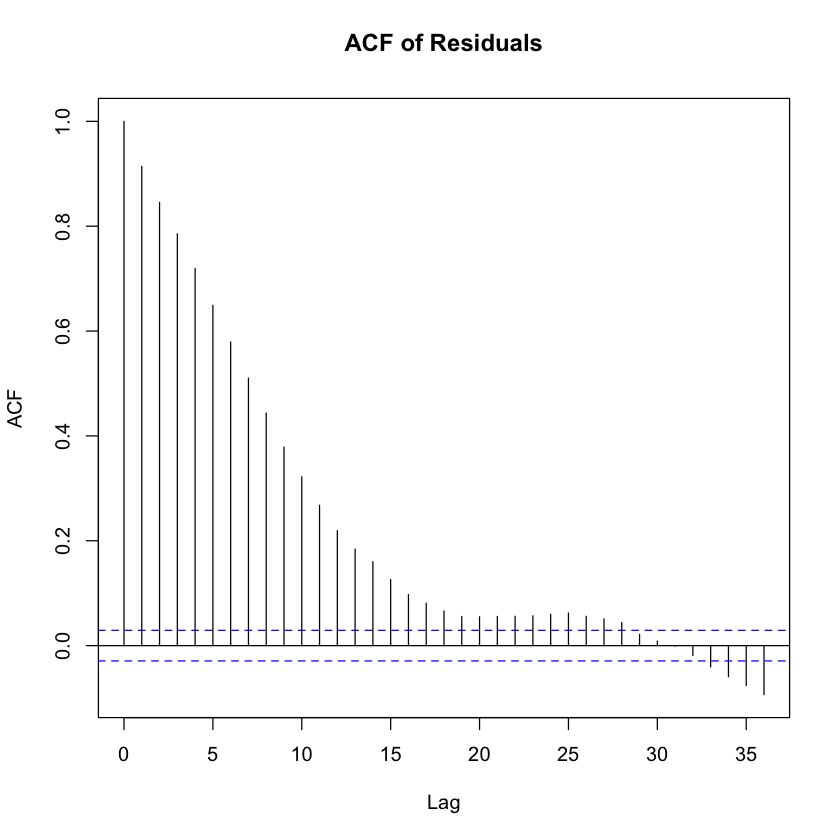

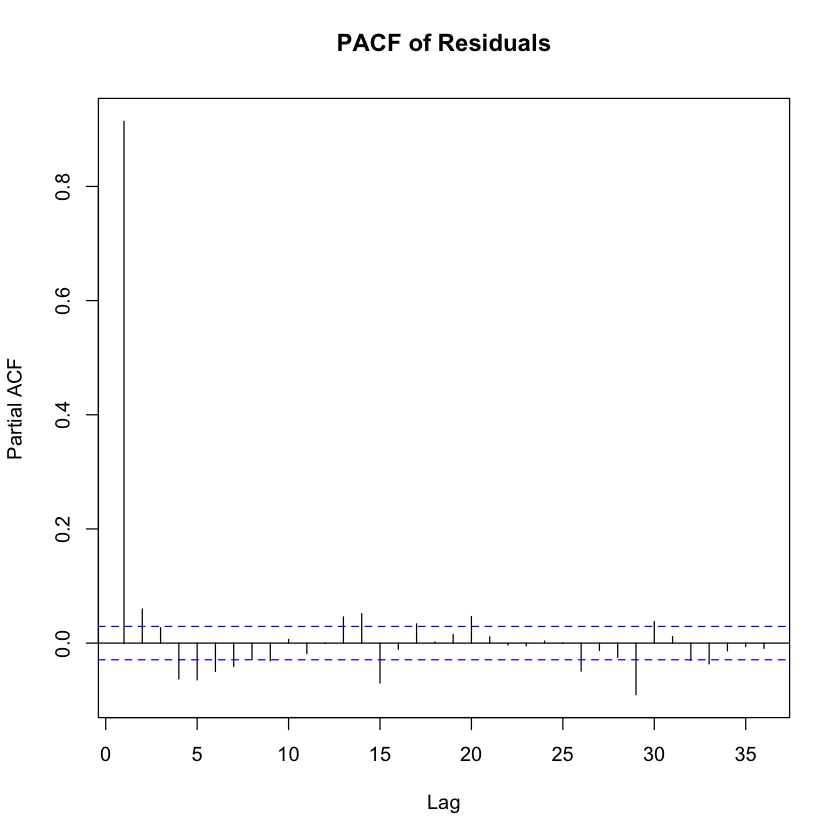

In [47]:
residuals <- residuals(gls_model_2)
acf(residuals, main="ACF of Residuals")
pacf(residuals, main="PACF of Residuals")

In [48]:
Box.test(residuals, type = "Ljung-Box")


	Box-Ljung test

data:  residuals
X-squared = 3768.9, df = 1, p-value < 2.2e-16


As the autocorrelation is still there, we choose to move to another model, built just to handle autocorrelation

## ARIMAX

Given the limitations observed in the GLS approach for addressing all forms of autocorrelation, we try using an AutoRegressive Integrated Moving Average with eXogenous variables (ARIMAX) model. This model extends the ARIMA (AutoRegressive Integrated Moving Average) framework by incorporating external (exogenous) variables into the equation.
The ARIMAX model is constructed as follows:
- AR (AutoRegressive): models the current value of the series as a function of its previous values. The autoregressive part indicates that the evolving variable of interest is regressed on its own lagged values.
- I (Integrated): deals with differencing the observational data to achieve stationarity, although in our case, as we will see, the data is already stationary
- MA (Moving Average): captures the dependency between an observation and a residual error from a moving average model applied to lagged observations. It helps in smoothing out the series and addressing short-term correlations.
- X (Exogenous Variables): allows the ARIMAX model to account for the influence of outside factors on the time series of interest. These variables are not modeled within the time series dynamics but are considered additional inputs that impact the series.
Transitioning to an ARIMAX model facilitates a more nuanced understanding of time series data by allowing the incorporation of external factors that influence the series, alongside modeling the intricate autocorrelation patterns not adequately captured by GLS.

But first, we check for stationarity using the Augmented Dick Fuller Test (ADF), which is a statistical test used to determine whether a time series is stationary, specifically whether it has a unit root, which is indicative of non-stationarity. The ADF test is a hypothesis test where the null hypothesis ($H_0$) says that the time series has a unit root (and is thus non-stationary). The alternative hypothesis ($H_1$) suggests that the time series does not have a unit root, implying it is stationary or can be made stationary through differencing.

In [49]:
adf.test(data_regression$gdp)
adf.test(data_regression$pol_stability)
adf.test(data_regression$co2_emission)
adf.test(data_regression$research)
adf.test(data_regression$decorr_fertility)

Warning message in adf.test(data_regression$gdp):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  data_regression$gdp
Dickey-Fuller = -9.8752, Lag order = 16, p-value = 0.01
alternative hypothesis: stationary


Warning message in adf.test(data_regression$pol_stability):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  data_regression$pol_stability
Dickey-Fuller = -10.723, Lag order = 16, p-value = 0.01
alternative hypothesis: stationary


Warning message in adf.test(data_regression$co2_emission):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  data_regression$co2_emission
Dickey-Fuller = -10.474, Lag order = 16, p-value = 0.01
alternative hypothesis: stationary


Warning message in adf.test(data_regression$research):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  data_regression$research
Dickey-Fuller = -9.9602, Lag order = 16, p-value = 0.01
alternative hypothesis: stationary


Warning message in adf.test(data_regression$decorr_fertility):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  data_regression$decorr_fertility
Dickey-Fuller = -10.84, Lag order = 16, p-value = 0.01
alternative hypothesis: stationary


As the pvalue is <0.01, we reject the null hypothesis and know that the serie is stationary, or can be made stationary. Now we move on to implementing the ARIMAX model, using `auto.arima`, which is a function of the forecast package that finds the best hyperparameters $p,q,d$ for a given model.
An ARIMA model is described by three parameters: (p, d, q), where:
- p is the order of the autoregressive (AR) part,
- d is the degree of differencing required to make the series stationary,
- q is the order of the moving average (MA) part.

The mathematical representation of an ARIMA model is:

$\Phi(B)\Delta ^dy_t =\delta+\theta(B)\epsilon_t$

where:
- $y_t$ is the time series at time $t$,
- B is the backshift operator, such that $B^ky_t =y_{t-k}$
- $\Delta^d=(1−B)^d$ represents the differencing operator to achieve stationarity,
- $\Phi(B)=1−\phi_1B−\phi_2B^2-\dots-\phi_pB^p$ is the AR polynomial of order $p$
- $\theta(B)=1+\theta_1B+\theta_2B^2+\dots+\theta_qB^q$ is the MA polynomial of order $q$
- $\delta$ is a constant (intercept term),
- $\epsilon_t$ is the error term, which is assumed to be white noise.

`auto.arima` also estimates the best lambda for the Box-Cox transformation, a transformation that was designed to stabilize the variance and make a dataset more closely conform to the assumption of normality. Mathematically, given a dataset $y$ with $y_i\geq0\,\,\forall i$ and parameter $\lambda$, 

$y(\lambda)=\begin{cases}
\frac{y^\lambda-1}{\lambda} \qquad \text{if } \lambda>0 \\
log(y)\quad\,\,\, \text{if } \lambda=0
\end{cases}$

In [50]:
gdp_ts <- ts(data_regression$gdp)
exog_vars <- as.matrix(data_regression[, c("pol_stability", "co2_emission", "research", "dummy_F", "dummy_30_60", "dummy_60_plus", "decorr_fertility")])
arimax_model <- auto.arima(gdp_ts, xreg = exog_vars, max.p = 7, max.q = 7, max.P = 7, max.Q = 7, max.order = 21, max.d = 7, max.D = 7, lambda = "auto")
summary(arimax_model)

Series: gdp_ts 
Regression with ARIMA(1,0,1) errors 
Box Cox transformation: lambda= -0.8451986 

Coefficients:
         ar1      ma1  intercept  pol_stability  co2_emission  research
      0.9149  -0.0774     0.9655          1e-04         6e-03     8e-04
s.e.  0.0068   0.0166     0.0031          0e+00         3e-04     3e-04
      dummy_F  dummy_30_60  dummy_60_plus  decorr_fertility
       0.0048       0.0118         0.0073           -0.0316
s.e.   0.0008       0.0011         0.0027            0.0012

sigma^2 = 6.507e-05:  log likelihood = 15336.13
AIC=-30650.26   AICc=-30650.21   BIC=-30579.72

Training set error measures:
                     ME     RMSE       MAE       MPE     MAPE    MASE
Training set 0.02038114 0.371539 0.1807438 0.0109281 2.273556 1.05521
                    ACF1
Training set -0.03127374

Now we check that all the parameters are statistically significant

In [51]:
coefficients <- coef(arimax_model)
var_coefficients <- summary(arimax_model)$var.coef
std_errors <- sqrt(diag(var_coefficients))
t_stats <- coefficients / std_errors
degrees_of_freedom <- length(residuals(arimax_model)) - length(coefficients) # degrees of freedom approximation
p_values <- 2 * pt(-abs(t_stats), df=degrees_of_freedom)
results <- data.frame(Coefficients = coefficients,
                      StdError = std_errors,
                      TStatistic = t_stats,
                      PValue = p_values)
print(results)

                  Coefficients     StdError TStatistic        PValue
ar1               9.148805e-01 0.0067850600 134.837490  0.000000e+00
ma1              -7.740546e-02 0.0166025435  -4.662265  3.218042e-06
intercept         9.654529e-01 0.0030681969 314.664567  0.000000e+00
pol_stability     8.497375e-05 0.0000303813   2.796909  5.181327e-03
co2_emission      5.986906e-03 0.0002971711  20.146329  1.710630e-86
research          8.151699e-04 0.0002541571   3.207346  1.349047e-03
dummy_F           4.820674e-03 0.0007785935   6.191516  6.490180e-10
dummy_30_60       1.178247e-02 0.0010740501  10.970130  1.188662e-27
dummy_60_plus     7.312241e-03 0.0026963101   2.711944  6.714430e-03
decorr_fertility -3.163406e-02 0.0011523654 -27.451418 1.602917e-153


As all the coefficients are significant at the 0.05 level, we will move on to plot the model

Don't know how to automatically pick scale for object of type <ts>. Defaulting to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting to continuous.


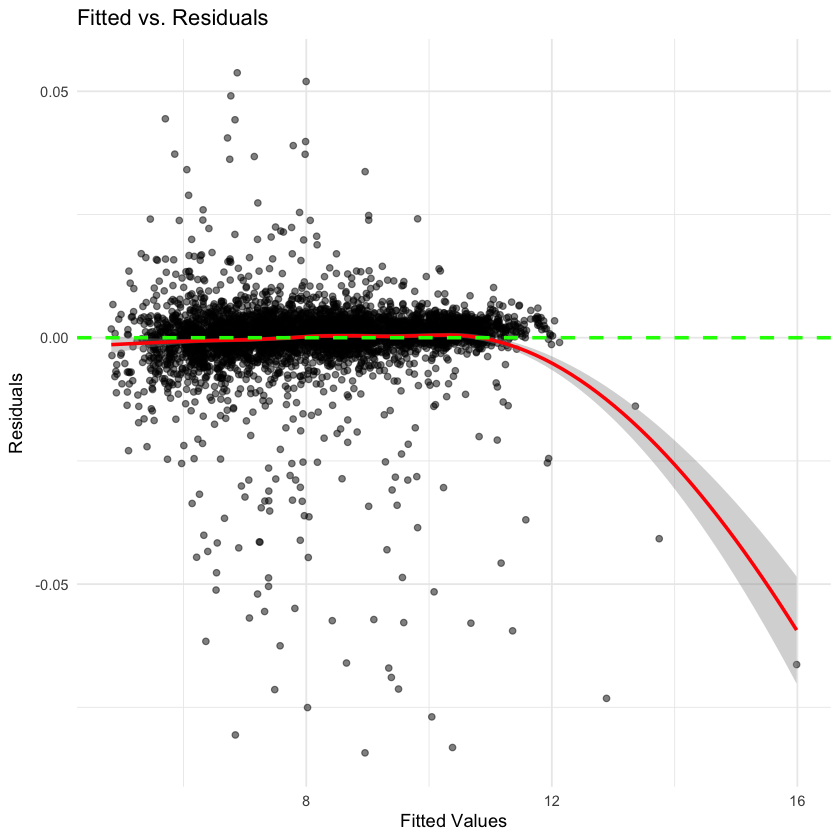

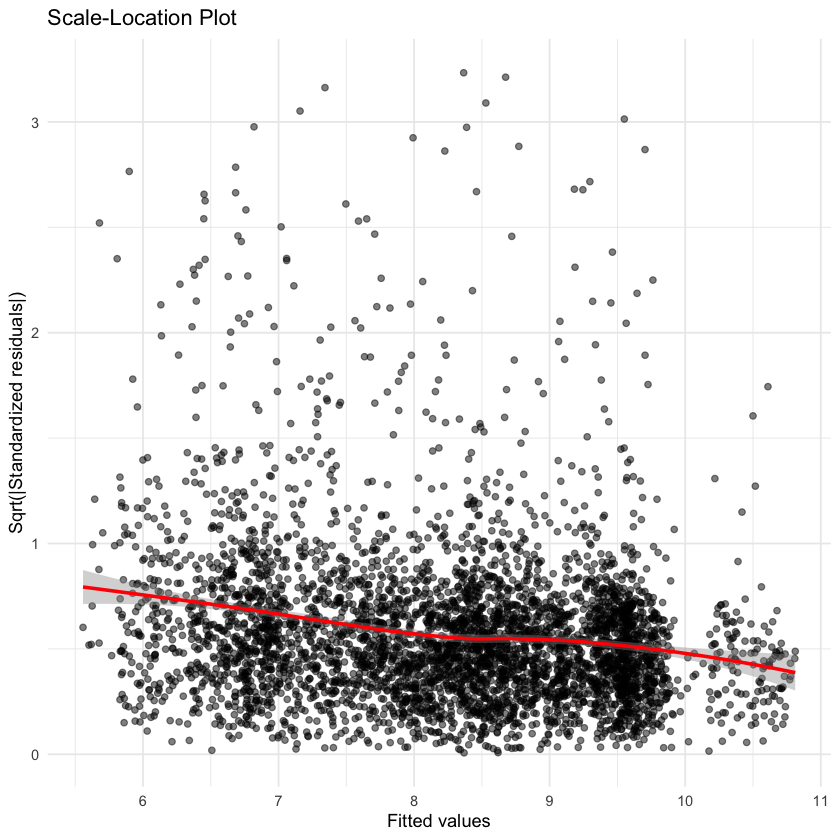

In [52]:
data_for_ggplot <- data.frame(
  Fitted = fitted(arimax_model),
  Residuals = residuals(arimax_model)
)
ggplot(data_for_ggplot, aes(x = Fitted, y = Residuals)) +
  geom_point(alpha = 0.5) +
  geom_smooth(aes(y = Residuals),
              method = "loess",
              formula = "y ~ x",
              color = "red"
  ) +
  geom_hline(yintercept = 0, color = "green", linetype = "dashed", size = 1) +
  labs(x = "Fitted Values", y = "Residuals", title = "Fitted vs. Residuals") +
  theme_minimal()
std_resid <- resid(arimax_model) / sd(resid(arimax_model))
data_for_plot <- data.frame(
  Fitted = fitted(gls_model_2),
  SqrtAbsStdResid = sqrt(abs(std_resid))
)

ggplot(data_for_plot, aes(x = Fitted, y = SqrtAbsStdResid)) +
  geom_point(alpha = 0.5) +
  geom_smooth(aes(y = SqrtAbsStdResid),
              method = "loess",
              formula = "y ~ x",
              color = "red"
  ) + 
  labs(x = "Fitted values",
       y = "Sqrt(|Standardized residuals|)",
       title = "Scale-Location Plot"
  ) +
  theme_minimal()


As the model is exceedingly close to having no errors, we plot the ACF and PACF to ensure that no autocorrelation is present

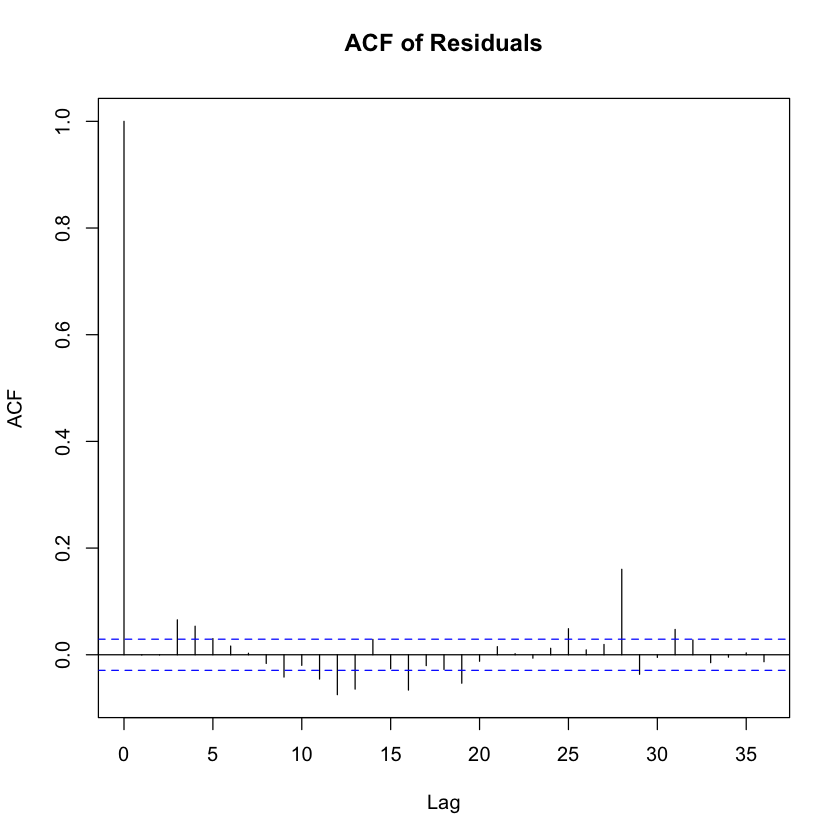

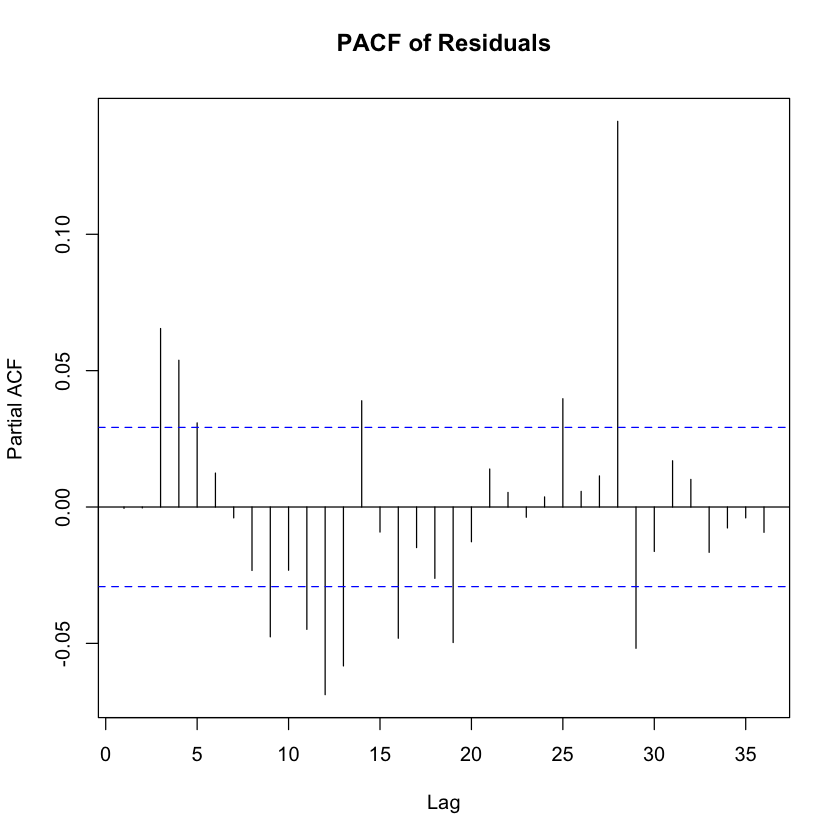

In [53]:
residuals <- residuals(arimax_model)
acf(residuals, main = "ACF of Residuals")
pacf(residuals, main = "PACF of Residuals")

The errors of the model are negligible, we can draw some conclusions from the model:
- AR1 coefficient: indicates a strong positive correlation between observations at time $t$ and $t-1$, aligning with expectations. This is consistent with the nature of GDP, where its value at any given moment tends to be significantly influenced by its immediate past;
- MA coefficient: although modest, its negative value indicates that errors from the immediate past tend to slightly decrease the current value. This suggests a corrective mechanism in the model, where past prediction errors are taken into account to adjust the current GDP estimate downwards;
- Intercept: significantly lower compared to all previously estimated intercepts, which we believe more accurately reflects reality, historically, it's evident that an economy consisting solely of a population, without the integration of factors like technology, governance, and infrastructure, tends to be less productive;
- Political stability: small, yet positive influence, aligning with the expectation that a nation with greater stability tends to have a higher GDP per capita on average; the minimal magnitude could stem from the aggregation of upper and lower estimates, however this approach was necessitated by the absence of more refined data, with fewer extreme values
- CO2 Emissions per capita: seems to be slightly positive correlated with gdp, which is to be expected
- Decorrelated Fertility: when accounted for CO2 Emission, fertility is quite negatively correlated, with a decrease in Fertility leading to quite a significant increase in GDP
- Research: There is a slight positive correlation between research expenditure and GDP per capita, which is to be expected
- Dummy Free: being classified as a free country shows a slight positive correlation with a higher GDP, although the magnitude of this effect is not as substantial as anticipated. This observation may reflect a narrowing gap between free and less free economies, potentially due to the emergence and success of hybrid authoritarian regimes (such as those in China, Singapore, etc.), which have managed to achieve significant economic growth despite limited political freedoms
- Dummy_30_60 and Dummy_60_plus: indicates a slight economic advantage for countries situated further from the equator, revealing a 'Goldilocks' zone for economic prosperity situated between 30 and 60 degrees latitude, countries within this optimal latitude range tend to demonstrate superior economic performance; this advantage marginally declines for countries located beyond 60 degrees latitude, however this reduction  may be influenced by nations in the southern parts of Africa and South America, suggesting geographical location plays a significant role in economic outcomes, with certain latitudes offering more favorable conditions than others